<a href="https://colab.research.google.com/github/HugoKD/byoRNA/blob/main/ByoRna_q%3D0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random as rd

**Réferences :** <br>
Pour la partie DSP  :

*  Model-based design and control of a small-scale integrated (Morten Ryberg Wahlgreen et al. / IFAC PapersOnLine 55-7 (2022)
continuous end-to-end mAb platform)
*  **Modeling and Simulation of Upstream and
Downstream Processes for Monoclonal
Antibody Production**

Pour la partie USP :

*   *équations de Monod*

## POO

On va faire un poo en python pour simuler le process de filtration. Chaque filtre possède une certaine affinité, des certaines caractéristiques. On veut arriver à un résultat optimal en un nombre d'étapes minimales -> programation sous contraintes. On veut un nombre de step min et un quantité d'ARN maximale (ou alors une pureté maximale). Pour l'instant on ne considère que la taille de la molécule d'interêt. <br><br>
De base on part d'une population de x% d'ARN,y% ADN, z% débris, w% de protéines, v% de virus et p% de petites molécules -> fixé. La masse totale de la mixture,elle n'est pas fixée. Cf USP

#### USP

In [ ]:
# Modèle basée sur les  équations de Monod pour simuler un process Up Stream

class USP:
    def __init__(self,taille,feed, mu_max=0.4, K_s=0.9, Y_E=0.8, q_G=0.1, q_O=0.5, m=0.01, G0=20, X0=0.4, E0=0, O0=100):
        """Initialisation de la classe USP"""
        self.mu_max = mu_max  # taux de croissance spécifique maximal (h^-1)
        self.K_s = K_s  # constante de saturation de Monod pour le glucose (g/L)
        self.Y_E = Y_E  # yield de l'éthanol sur le glucose (g/g)
        self.q_G = q_G  # taux spécifique de consommation de glucose (g/g.h)
        self.q_O = q_O  # taux spécifique de consommation d'oxygène (%/g.h)
        self.m = m  # taux de maintenance (h^-1)
        # concentrations initiales
        self.G0 = G0  # c_i de glucose (g/L)
        self.X0 = X0  # c_i de biomasse (g/L)
        self.E0 = E0  # c_i d'éthanol (g/L)
        self.O0 = O0  # c_i d'oxygène (%)
        self.solution = None  # Variable pour stocker la solution
        self.taille = taille # taille du bio réacteur (L)
        self.feed = feed

    def model(self, y, t):
        """
        Définir les équations de monod
        :param y: conditions initiales
        :param t: temps final
        :return : incrément des éq partielles
        """
        G, X, E, O = y
        mu = self.mu_max * (G / (self.K_s + G))
        dG_dt = -mu * X - self.q_G * X
        dX_dt = (mu - self.m) * X
        dE_dt = self.Y_E * (self.q_G - mu) * X
        dO_dt = -self.q_O * X
        return [dG_dt, dX_dt, dE_dt, dO_dt]

    def get_solution(self, t_end=30, n=100, plot=False):
        """
        Résoudre les eq de Monod
        :param: t_end: temps de fin
        :param: n: subdivision spatiale
        :param: plot: booléen pour afficher le graphique
        :return: G, X, E, O, respecitement les concentrations de glucose, biomasse, éthanol et oxygène
        """
        t = np.linspace(0, t_end, n)  # en heure
        y0 = [self.G0, self.X0, self.E0, self.O0]
        # Résoudre les équa diffs avec odeint
        self.solution = odeint(self.model, y0, t)
        G, X, E, O = self.solution.T
        if plot:
            # Créer le graphique
            plt.figure(figsize=(10, 6))
            plt.plot(t, G, label='Glucose')
            plt.plot(t, X, label='Biomasse')
            plt.plot(t, O, label='Oxygène (%)')
            plt.xlabel('Temps (h)')
            plt.ylabel('Concentration (g/L)')
            plt.title('Modèle de Sonnleitner et Käppeli et de Monod')
            plt.legend()
            plt.grid(True)
            plt.show()
            self.update_feed()
        else:
          self.update_feed()
          return G, X, E, O

    def get_masse_X(self):
        """
        :param: taille : en L, taille du bio réacteur
        :return: masse de biomasse en g
        """
        if self.solution is None:
            self.get_solution(plot=False)
        G, X, E, O = self.solution.T
        return X[-1] * self.taille  # return g de biomasse

    def update_feed(self):
      """
      A partir d'un feed, avec des données de base, on retourne un feed avec en plus, le nombre de chaque type de molécule, leur concentration ainsi que leur poids.
      :return: la masse de chaque molécule du feed : ADN,ARN,tiny mol, virus,debris
      """
      i = 0
      for molecule in self.feed :
        if 'pourcentage' not in molecule.keys():
          print(molecule.keys())
          raise ValueError("Feed incomplet")
        molecule['poids'] = molecule['pourcentage']*self.get_masse_X()
        molecule['concentration'] = molecule['poids']/self.taille
        molecule['nombre'] = molecule["poids"]/molecule["poids_unitaire"]
        molecule["volume"] = self.taille * molecule['pourcentage']
        self.feed[i] = molecule
        i+=1

In [ ]:
dalton_to_gram = 1.66e-24
taille_reacteur = 10 #(L)

feed_initial = [ #we get more info thanks to the "update_feed" method of USP class (+nbr,poids,concentration)
    {'type': 'DNA', 'size': 0.06, 'pourcentage': 0.45, 'poids_unitaire': 200 * 330 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.01},
    {'type': 'RNA', 'size': 0.05, 'pourcentage': 0.45, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'charge' : -1, 'affinity' :  0.06},
    {'type': 'protein', 'size': 0.02, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram,  'charge' : 2, 'affinity' : 0.01},
    {'type': 'virus', 'size': 0.01, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'charge' : 0, 'affinity' :  0.01},
    {'type': 'tiny_mol', 'size': 0.001, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram,  'charge' : -1, 'affinity' :  0.005},
    {'type': 'debris', 'size': 0.1, 'pourcentage': 0.08, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.001}
]

#### Filtration par taille ou par charge

In [ ]:
## Classe DSP pour simuler (fonction simulate) ou visualiser (fonction visu) un downstream process entier (plusieurs filtrations à la chaine possible)
# Simplification en proportion la masse équivaut au volume.

class DSP:

    def __init__(self, feed, temperature,filtrations):
        """
        Initialisation de la classe DSP.
        :param feed: mélange de molécules initial
        :param temperature: température de la solution
        :param filtrations: ensemble des filtrations à effectuer, une liste de dictionnaires décrivant chaque étape de filtration
        """
        self.feed = feed
        self.temperature = temperature
        self.filtrations = filtrations
        self.data = None


    def simulate(self , transform, display = True):
        """
        Simule le processus de filtration.
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :param display: booléen indiquant si les résultats doivent être affichés.
        :return: un dictionnaire avec les résultats de la filtration.
        """
        filtration_results = self.feed
        history = []
        for filtration in self.filtrations:
            if filtration['type_filtration'] == 'size': #soit une filtration par taille
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size =filtration['filter_size'], filter_charge = None, pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(type_ = filtration['type_'], transform = False)
            elif filtration['type_filtration'] == 'charge':#soit une filtration par charge
                filtration_ = Filtration(type_filtration = filtration['type_filtration'] ,feed = filtration_results,
                                         filter_size=None, filter_charge = filtration['filter_charge'], pressure = filtration['pressure'],flow_rate = filtration['flow_rate'], temperature = self.temperature)
                filtration_.perform_filtration(transform = False)
            elif filtration['type_filtration'] == 'chromatography':
                filtration_ = Filtration(type_filtration = 'chromatography', feed = filtration_results, temperature = self.temperature, flow_rate = filtration['flow_rate'], pressure = None)
                filtration_.perform_filtration(transform = False)
            else : raise ValueError("Type de filtration inconnu")
            filtration_results = filtration_.get_results()['filtrat']
            history.append(filtration_results)
        if display :
          print(f"initial : {self.feed}")
          print(f"filtrat: {filtration_results}")
          print(f"residu: {filtration_.get_results()['residu']}")
          self.data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu'], 'history' : history}
          return self.data
        else :
          self.data = {'initial' : self.feed, 'filtrat' : filtration_.get_results()['filtrat'], "residu" : filtration_.get_results()['residu'], 'history' : history}
          return self.data

    def visu(self,transform = False):
        """
        Visualise le processus de filtration en affichant un graphique des poids des différents composants
        :param transform: booléen indiquant si l'on transforme le feed initial ou non
        :return: un dictionnaire avec les résultats de la filtration
        """
        data = self.data if self.data else self.simulate(transform)
        data = {'initial' : data['initial'], 'filtrat' : data['filtrat'], "residu" :data['residu']}
        types = ["DNA", "RNA", "protein", "virus", "tiny_mol", "debris"]
        initial_weights = [item["poids"] for item in data["initial"]]
        filtrat_weights = [item["poids"] for item in data["filtrat"]]
        residu_weights = [next((item["poids"] for item in data["residu"] if item["type"] == t), 0) for t in types]

        # Creating the bar chart
        bar_width = 0.25
        x = np.arange(len(types))

        plt.figure(figsize=(10, 6))
        plt.bar(x - bar_width, initial_weights, width=bar_width, label='Initial')
        plt.bar(x, filtrat_weights, width=bar_width, label='Filtrat')
        plt.bar(x + bar_width, residu_weights, width=bar_width, label='Residu')

        plt.xlabel('Type')
        plt.ylabel('Poids')
        plt.title('Poids par Type pour Initial, Filtrat et Residu')
        plt.xticks(x, types)
        plt.legend()
        plt.show()
        return data

    def calculate_purity(self):
        """
        Calcule l'évolution de la purété au fur et à mesure des filtrations
        : return : liste des puretés au fur et à mesure des filtrations
        """
        history = self.data['history']
        purity_history = []
        purity_history.append(next((molecule['poids'] for molecule in self.feed if molecule['type'] == 'RNA'), 0)/sum([molecule['poids'] for molecule in self.feed]))
        for stage in history:
            total_weight = sum([molecule['poids'] for molecule in stage])
            rna_weight = next((molecule['poids'] for molecule in stage if molecule['type'] == 'RNA'), 0)
            purity = (rna_weight / total_weight) * 100 if total_weight > 0 else 0
            purity_history.append(purity)

        # Creating the line chart for RNA purity
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(purity_history)), purity_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Étape de filtration')
        plt.ylabel('Pureté de l\'ARN (%)')
        plt.title('Pureté de l\'ARN à travers les étapes de filtration')
        plt.grid(True)
        plt.show()

        return purity_history




In [ ]:
## Classe Filtration pour simuler une seule filtration (soit une chromato par charge soit une filtration frontale pour l'instant)
# TODO : Check concentration

class Filtration:
    def __init__(self, type_filtration, feed , temperature,flow_rate,pressure, filter_charge = None, filter_size = None):
        """
        Initialise une instance de la classe Filtration
        :param type_filtration: type de filtration ('charge', 'size', 'chromatography')
        :param feed: mélange à filtrer avec divers composants
        :param temperature: température en Kelvin
        :param pressure: pression appliquée pendant la filtration
        :param flow_rate: débit à travers le filtre
        :param filter_charge: charge de la résine (pour la chromatographie par charge)
        :param filter_size: taille du filtre en nm (pour la chromatographie par taille).
        """
        self.type_filtration = type_filtration
        self.feed = feed  # Mixture to filter with various components
        self.filter_size = filter_size  # Filter size in nm (for size-based chromatography)
        self.filter_charge = filter_charge  # Resin charge (for charge-based chromatography)
        self.flow_rate = flow_rate  # Flow rate through the filter
        self.pressure = pressure  # Pressure applied during filtration
        self.temperature = temperature  # Temperature in Kelvin
        self.filtrat = []  # Fraction that passed through the filter
        self.residu = []  # Fraction that did not pass through the filter

    def perform_filtration(self, type_ = None, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True):
        """
        Gère le type de filtration à effectuer de manière automatique
        Ajuste les constantes du modèle en fonction de l'influence des paramètres expérimentaux.
        :param type_: type de modèle de filtration ('logistique' ou 'passage')
        :param threshold: seuil pour la filtration.
        :param k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat
        """

        if self.type_filtration == 'charge':
            adjusted_k_inf = k_inf * self.flow_rate * self.pressure / self.temperature
            adjusted_k_sup = k_sup * self.flow_rate * self.pressure / self.temperature
            adjusted_threshold = threshold * self.flow_rate / self.temperature
            self.filtration_by_charge(type_, adjusted_threshold, k, adjusted_k_inf, c_inf, adjusted_k_sup, c_sup, transform)
        elif self.type_filtration == 'size':
            adjusted_k_inf = k_inf * self.flow_rate * self.pressure / self.temperature
            adjusted_k_sup = k_sup * self.flow_rate * self.pressure / self.temperature
            adjusted_threshold = threshold * self.flow_rate / self.temperature
            self.filtration_by_size(type_, threshold, k, k_inf, c_inf, k_sup, c_sup, transform)
        elif self.type_filtration == 'chromatography':
            self.filtration_with_chromatography()
        else:
            raise ValueError("Type de filtration inconnu")

    def filtration_by_charge(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True): # Parametres arbitraires
        """
        Effectue une filtration par charge. Par sur pour l'update de la concentration des molécules.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        P = []
        for molecule in self.feed:
            charge = molecule['charge']
            x = charge * self.filter_charge
            p = 1 / (1 + np.exp((x - threshold)))

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
            mol_filtrat["volume"] = mol_filtrat["volume"] *p
            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
            mol_residu["volume"] = mol_residu["volume"] *(1-p)

            self.residu.append(mol_residu)


            total_volume_filtrat = sum(mol['volume'] for mol in self.filtrat)
            total_volume_residu = sum(mol['volume'] for mol in self.residu)
            total_volume_feed = sum(mol['volume'] for mol in self.feed)


            for mol in self.filtrat:
                mol['concentration'] = mol['poids'] / total_volume_filtrat

            for mol in self.residu:
                mol['concentration'] = mol['poids'] / total_volume_residu


            if transform:
                self.feed = self.filtrat

    def filtration_by_size(self, type_, threshold=0.1, k=5, k_inf=4.2, c_inf=1.3, k_sup=15, c_sup=1.1, transform=True):
        """
        Effectue une filtration par taille.
        :param type_: type de modèle de filtration ('logistique' ou 'passage').
        :param threshold, k, k_inf, c_inf, k_sup, c_sup: constantes pour les fonctions logistiques.
        :param transform: booléen indiquant si le feed doit être transformé par le filtrat.
        """
        for molecule in self.feed:
            size = molecule['size']
            r = size / self.filter_size

            if size <= self.filter_size:  # Molecule smaller than the filter size
                if type_ == 'logistique':
                    p = 1 / (1 + math.exp(-k_inf * (c_inf - r)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = (1 - (size / self.filter_size) ** 2) ** 1
                else:
                    raise ValueError("Type de filtre inconnu")
            else:
                if type_ == 'logistique':
                    p = 1 - 1 / (1 + math.exp(-k_sup * (r - c_sup)))  # Logistic function for probability
                elif type_ == 'passage':
                    p = 0
                else:
                    raise ValueError("Type de filtre inconnu")

            poids_residu = molecule["poids"] * (1 - p)
            poids_filtrat = molecule["poids"] * p

            mol_filtrat = molecule.copy()
            mol_filtrat["poids"] = poids_filtrat
            mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
            mol_filtrat["volume"] = mol_filtrat["volume"] *p

            self.filtrat.append(mol_filtrat)

            mol_residu = molecule.copy()
            mol_residu["poids"] = poids_residu
            mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
            mol_residu["volume"] = mol_residu["volume"] *(1-p)

            self.residu.append(mol_residu)


        total_volume_filtrat = sum(mol['volume'] for mol in self.filtrat)
        total_volume_residu = sum(mol['volume'] for mol in self.residu)
        total_volume_feed = sum(mol['volume'] for mol in self.feed)


        for mol in self.filtrat:
            mol['concentration'] = mol['poids'] / total_volume_filtrat

        for mol in self.residu:
            mol['concentration'] = mol['poids'] / total_volume_residu


        if transform:
            self.feed = self.filtrat

    def filtration_with_chromatography(self,L = 20,D = .01,Nx = 1000,Nt = 10000, T = 300,pulse_duration = 60
                                       ,solvent_viscosity = 0.5,epsilon_c = .4,epsilon_p = .5,pH =7.5,
                                       pI = 7.5,conductivity = .5,ligand_density = .7,particle_size = .005,elution_volume = 1, transform = False):
      #on suppose de plus une élution parfaite
      #on enchaine les chromatographie de manière 1D
      #mieux vaut re travailler le fonctionnement des classes pour n'avoir qu'a gerer ici les para de simulation et non d experimentation ! Ici on gère le fonctionnement de la chromato
      #self.filtrat ici = ce qui est retenu et résidu ce que perdu
      #on suppose que tout le liquide injecté s'est évacué

        M = []
        for molecule in self.feed :
          #molecule_size =~0.001
          chromato = Chromatography(
                L=L, temperature=self.temperature, v=self.flow_rate, affinity=molecule['affinity'],
                solvent_viscosity=solvent_viscosity, epsilon_c=epsilon_c,
                epsilon_p=epsilon_p, pH=pH, pI=pI, conductivity=conductivity,
                ligand_density=ligand_density,elution_volume = elution_volume, molecule_size = molecule["size"],particle_size = particle_size,
                D=D, Nx=Nx, Nt=Nt, pulse_duration=pulse_duration, pulse_concentration= molecule["concentration"], feed = self.feed, T = T
            )
          chromato.perform_chromatography()
          m = chromato.calculate_mass_recovered()

          M.append(m)
          print(M)
          mol_filtrat, mol_residu = molecule.copy(), molecule.copy()

          mol_filtrat["poids"] = m
          mol_filtrat["nombre"] = mol_filtrat["poids"]/mol_filtrat["poids_unitaire"]
          mol_filtrat["volume"] = chromato.elution_volume
          mol_filtrat["concentration"] = mol_filtrat["poids"]/mol_filtrat["volume"]

          self.filtrat.append(mol_filtrat)

          mol_residu["poids"] =  molecule["poids"] - M[-1]
          mol_residu["nombre"] = mol_residu["poids"]/mol_residu["poids_unitaire"]
          mol_residu["volume"] = molecule['volume']
          mol_residu["concentration"] = mol_residu["poids"]/mol_residu["volume"]

          self.residu.append(mol_residu)


        if transform :
          self.feed = self.filtrat


    def get_results(self):
        return {
            'filtrat': self.filtrat,
            'residu': self.residu
        }

In [ ]:
"""Influence des paramètres n et m sur la fonction de passage"""

def passage_probability(pore_diameter, particle_diameter, n, m):
    return (1 - (particle_diameter / pore_diameter) ** n) ** m

pore_diameter = 50  # 50 nm

particle_diameters = np.linspace(0, 50, 1000)  # De 1 nm à 100 nm

# Différentes valeurs de n et m
ns = [1, 2, 4]
ms = [1, 2, 4]

fig, ax = plt.subplots(len(ns), len(ms), figsize=(15, 10), sharex=True, sharey=True)

for i, n in enumerate(ns):
    for j, m in enumerate(ms):
        probabilities = [passage_probability(pore_diameter, d, n, m) for d in particle_diameters]
        ax[i, j].plot(particle_diameters, probabilities)
        ax[i, j].set_title(f'n={n}, m={m}')
        ax[i, j]
        ax[i, j].set_ylim(0, 1)
        ax[i, j].set_xlabel('Particle Diameter (nm)')
        ax[i, j].set_ylabel('Proba de Passage')

plt.tight_layout()
plt.show()


#### Modélisation chromato basée sur les équations de transfert de masse

Explenation of each term (cf *Integrated design of biopharmaceutical manufacturing processes:
Operation modes and process conﬁgurations for monoclonal antibody
production* paper) :


*   **c: Concentration of the bulk liquid phase.**

    This refers to the concentration of the solute or substance in the main liquid stream that is flowing through the column.


*   **cp: Intra-particle liquid phase concentration.**

    concentration of the solute inside the porous particles of the column, which may differ from the bulk concentration due to mass transfer processes.

*  **εp: Particle porosity.**

    fraction of the particle volume that is not occupied by the solid phase (ie resin) inside the column particles.

*   **εc: Column porosity.**

    This parameter represents the fraction of the column volume that is occupied by the liquid phase.


*   rp: Particle radius.

    The radius of the porous particles within the column.











Colonne NatrixQ, capture au niveau de la résine les molécules d'interêts qui sont llibérées après élution <br>
Critère du Ph < 7.5

In [1]:
# Probleme ne considère pas l'interraction avec les autres molécules
# Fait fit des problèmes de competitivité, pb?
# Le code ne traite qu'un seul composant sans interaction compétitive, ce qui est une simplification par rapport au GRM.
# Pas de diffusion radiale ni gradient radial
# voies d'améliorations possibles  : GRM/ Collocation orthogonale
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size,elution_volume):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # to help determine the opti ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule
        self.elution_volume = elution_volume

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_


    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
         (?transfer of molecules from the mobile phase into the pores of the particles)
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        Représente les molécules entrant ou sortant de l'espace poreux où elles ne sont pas liées à la phase stationnaire
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction Rp
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        => Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre
        :return: terme de réaction rp
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            #print(f"Time: {t}, c[0]: {self.c[0]}, c[-1]: {self.c[-1]}")
            #print(f"q[0]: {self.q[0]}, q[-1]: {self.q[-1]}")
            #print(f"affinity_factor: {self.calculate_affinity_factor()}")

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())


    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(1, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(2, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered

    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


    def calculate_purity(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        total_concentration = np.sum(self.c) + np.sum(self.cp) + np.sum(self.q)
        target_concentration = np.sum(self.q)
        print(f'total conc {total_concentration}')
        print(f'target conc {target_concentration}')
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity



    def calculate_purity_(self):
        """
        Calcule la pureté de la molécule cible dans la fraction collectée.
        """
        # Intégration des concentrations sur la longueur de la colonne
        total_concentration = np.trapz(self.c, dx=self.dx) + np.trapz(self.cp, dx=self.dx) + np.trapz(self.q, dx=self.dx)
        target_concentration = np.trapz(self.q, dx=self.dx)
        print(f'total conc_ {total_concentration}')
        print(f'target conc_ {target_concentration}')
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity

feed = feed_initial

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 700.0
v = 0.1
D = 0.01
Nx = 1000
Nt = 20000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.5
ligand_density = 0.7
elution_volume = 1 #L

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI = pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size,
    elution_volume = elution_volume
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print(f"purity {chromato.calculate_purity()}")
print(f"Final Bound Concentration: {final_bound_concentration}")

NameError: name 'Filtration' is not defined

In [43]:
m,y =chromato.calculate_mass_recovered(), chromato.get_yield()
print(m,y)

4.0925695178928505 0.6820949196488084


[3.260214408753656]
[3.260214408753656, 6.515591504025547]
[3.260214408753656, 6.515591504025547, 0.7244927542053912]
[3.260214408753656, 6.515591504025547, 0.7244927542053912, 0.07244928163965099]
[3.260214408753656, 6.515591504025547, 0.7244927542053912, 0.07244928163965099, 0.055823518057761035]
[3.260214408753656, 6.515591504025547, 0.7244927542053912, 0.07244928163965099, 0.055823518057761035, 0.5270054966268758]
initial : [{'type': 'DNA', 'size': 0.06, 'pourcentage': 0.45, 'poids_unitaire': 1.0956e-19, 'charge': -1, 'affinity': 0.01, 'poids': 7.968543362869099, 'concentration': 0.7968543362869098, 'nombre': 7.273223222772086e+19, 'volume': 4.5}, {'type': 'RNA', 'size': 0.05, 'pourcentage': 0.45, 'poids_unitaire': 1.9189600000000002e-19, 'charge': -1, 'affinity': 0.06, 'poids': 7.968543362869099, 'concentration': 0.7968543362869098, 'nombre': 4.1525322898179736e+19, 'volume': 4.5}, {'type': 'protein', 'size': 0.02, 'pourcentage': 0.1, 'poids_unitaire': 1.9720800000000002e-20, 'cha

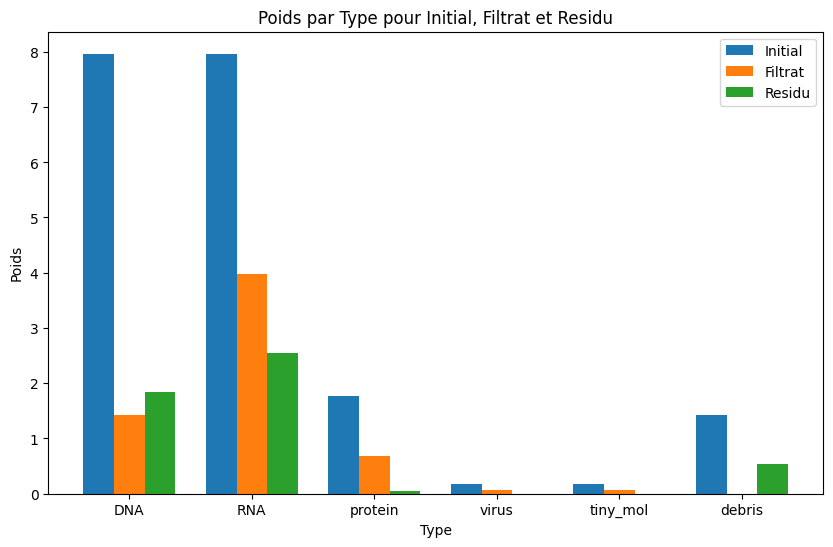

In [44]:
dalton_to_gram = 1.66e-24
taille_reacteur = 10 #(L)

feed_initial = [ #we get more info thanks to the "update_feed" method of USP class (+nbr,poids,concentration)
    {'type': 'DNA', 'size': 0.06, 'pourcentage': 0.45, 'poids_unitaire': 200 * 330 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.01},
    {'type': 'RNA', 'size': 0.05, 'pourcentage': 0.45, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'charge' : -1, 'affinity' :  0.06},
    {'type': 'protein', 'size': 0.02, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram,  'charge' : 2, 'affinity' : 0.01},
    {'type': 'virus', 'size': 0.01, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'charge' : 0, 'affinity' :  0.01},
    {'type': 'tiny_mol', 'size': 0.001, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram,  'charge' : -1, 'affinity' :  0.005},
    {'type': 'debris', 'size': 0.1, 'pourcentage': 0.08, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.001}
]

usp = USP(feed = feed_initial, taille = taille_reacteur)
G, X, E, O = usp.get_solution(plot=False)

#print(f"masse totale USP de {usp.get_masse_X()}")
#print([f"{molecule['type']} {molecule['charge']}" for molecule in feed_initial])
#print(usp.feed)

process = DSP(
    usp.feed,
    temperature=293.15,
    filtrations =  [
    {'type_filtration': 'chromatography',
    'filter_size': 300,
    'type_' : 'passage',
    'flow_rate' : 0.1,
    },
    {'type_filtration': 'size',
    'filter_size': 0.08,
    'type_' : 'passage',
    'flow_rate' : 1.5,
    'pressure' : 2}
])

''''
                   ,
    {'type_filtration': 'size',
    'filter_size': 300,
    'type_' : 'passage',
    'flow_rate' : 1.5,
    'pressure' : 2},
    {
    'type_filtration': 'charge',
    'filter_charge': -1,
    'flow_rate' : 1.5,
    'pressure' : 2,}
'''

s = process.visu()

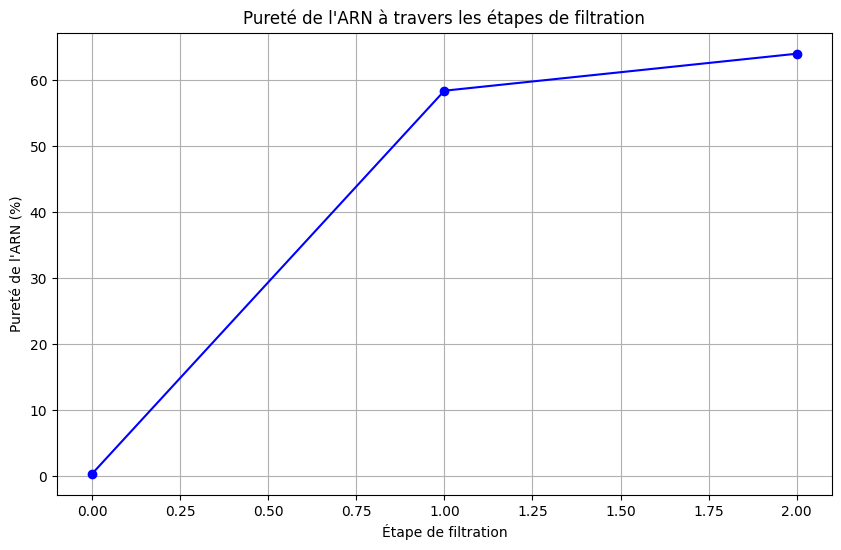

[0.40909090909090917, 58.406584665728865, 64.00705583855016]

In [45]:
process.calculate_purity()

## TEST

In [ ]:
feed_initial = [ #we get more info thanks to the "update_feed" method of USP class (+nbr,poids,concentration)
    {'type': 'DNA', 'size': 200, 'pourcentage': 0.45, 'poids_unitaire': 200 * 330 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.04},
    {'type': 'RNA', 'size': 340, 'pourcentage': 0.45, 'poids_unitaire': 340 * 340 * dalton_to_gram, 'charge' : -1, 'affinity' : 0.1},
    {'type': 'protein', 'size': 108, 'pourcentage': 0.10, 'poids_unitaire': 108 * 110 * dalton_to_gram,  'charge' : 2, 'affinity' : 0.02},
    {'type': 'virus', 'size': 100, 'pourcentage': 0.01, 'poids_unitaire': 100 * 10**9 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.01},
    {'type': 'tiny_mol', 'size': 10, 'pourcentage': 0.01, 'poids_unitaire': 1 * 180 * dalton_to_gram,  'charge' : -1, 'affinity' : 0.007},
    {'type': 'debris', 'size': 1000, 'pourcentage': 0.08, 'poids_unitaire': 200 * 5000 * dalton_to_gram, 'charge' : 0, 'affinity' : 0.02}
]


In [29]:
import numpy as np
import matplotlib.pyplot as plt

class ChromatographyGRM(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size, elution_volume, n_components):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # to help determine the opti ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule
        self.elution_volume = elution_volume

        # Ajout pour multi-composants
        self.n_components = n_components
        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros((n_components, Nx))
        self.cp = np.zeros((n_components, Nx))
        self.q = np.zeros((n_components, Nx))
        print(self.q.shape)
        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = np.array([self.c0(self.z) for _ in range(self.n_components)])
        self.cp = np.array([self.cp0(self.z) for _ in range(self.n_components)])
        self.q = np.array([self.q0(self.z) for _ in range(self.n_components)])

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self, component_index):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :param component_index: l'indice du composant pour lequel l'affinité est calculée
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity[component_index] * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI[component_index]) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_

    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
        pour tous les composants
        :param c: concentration de la phase mobile pour tous les composants
        :param cp: concentration dans les pores de la phase libre pour tous les composants
        :param q: concentration dans les pores de la phase liée pour tous les composants
        :return: terme de réaction R pour tous les composants
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(self.n_components)])
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        pour tous les composants
        :param c: concentration de la phase mobile pour tous les composants
        :param cp: concentration dans les pores de la phase libre pour tous les composants
        :param q: concentration dans les pores de la phase liée pour tous les composants
        :return: terme de réaction Rp pour tous les composants
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(self.n_components)])
        rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(self.n_components)])
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        => Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        pour tous les composants
        :param c: concentration de la phase mobile pour tous les composants
        :param cp: concentration dans les pores de la phase libre pour tous les composants
        :param q: concentration dans les pores de la phase liée pour tous les composants
        :return: terme de réaction Rq pour tous les composants
        """
        rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(self.n_components)])
        return rq

    def calculate_rp(self, c, cp, component_index):
        """
        Calcule le terme de réaction rp pour la phase mobile
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre
        :param component_index: l'indice du composant pour lequel rp est calculé
        :return: terme de réaction rp
        """
        affinity_factor = self.calculate_affinity_factor(component_index)
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q, component_index):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param component_index: l'indice du composant pour lequel rq est calculé
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor(component_index)
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        pour tous les composants
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx, axis=1)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx, axis=1) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                for i in range(self.n_components):
                    self.c[i, :] = self.pulse_concentration[i]
            else:
                print(self.c.shape)
                self.c[i:] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self, index):
        """
        Trace les résultats pour un composant spécifique donné par 'index'.

        Parameters:
        index (int): L'indice du composant à tracer.
        """
        # Vérifier que l'indice est valide
        if index < 0 or index >= self.c_history.shape[0]:
            raise ValueError("Index out of range")

        # Extraction des données pour le composant spécifié
        c_history = np.array(self.c_history)[index, :]
        cp_history = np.array(self.cp_history)[index, :]
        q_history = np.array(self.q_history)[index, :]

        # Configuration de la figure
        plt.figure(figsize=(12, 8))

        # Phase mobile
        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration (Component {})'.format(index + 1))
        plt.plot(np.linspace(0, self.L, self.Nx), c_history, label='Mobile Phase')
        plt.xlabel('Position (cm)')
        plt.ylabel('Concentration')
        plt.grid()

        # Concentration dans les pores (molécules libres)
        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules (Component {})'.format(index + 1))
        plt.plot(np.linspace(0, self.L, self.Nx), cp_history, label='Pore Phase - Free Molecules')
        plt.xlabel('Position (cm)')
        plt.ylabel('Concentration')
        plt.grid()

        # Concentration dans les pores (molécules liées)
        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules (Component {})'.format(index + 1))
        plt.plot(np.linspace(0, self.L, self.Nx), q_history, label='Pore Phase - Bound Molecules')
        plt.xlabel('Position (cm)')
        plt.ylabel('Concentration')
        plt.grid()

        # Affichage final
        plt.tight_layout()
        plt.show()



    def get_final_bound_concentration(self,index):
        return np.sum(self.q[index])

    def calculate_mass_recovered(self,index):
          mass_recovered = np.trapz(self.q[index], dx=self.dx, axis=1)
          return mass_recovered

    def get_yield(self,index):
          mass_recovered = self.calculate_mass_recovered()
          mass_injected = self.pulse_concentration * self.pulse_duration * self.v
          return np.sum(mass_recovered) / mass_injected

    # Ajoutez d'autres méthodes pour analyser les résultats (pureté, rendement, etc.)

# Exemple d'utilisation
feed = feed_initial

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 300.0
v = 0.1
D = 0.01
Nx = 1000
Nt = 10000
pulse_duration = 60
pulse_concentration = [1,1]
temperature = 293.15
solvent_viscosity = 0.5
affinity = [0.01, 0.005]
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = [7.5, 6.5]
conductivity = 0.5
ligand_density = 0.7
elution_volume = 1  # L

chromato = ChromatographyGRM(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI=pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size,
    elution_volume=elution_volume,
    n_components=2  # Nombre de composants
)

chromato.perform_chromatography()

(2, 1000)
(2, 1000)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinities, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_sizes, elution_volume):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L
        self.T = T
        self.v = v
        self.D = D
        self.Nx = Nx
        self.Nt = Nt
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration
        self.pulse_concentration = pulse_concentration
        self.particle_size = particle_size
        self.molecule_sizes = molecule_sizes  # Liste des tailles de molécules
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinities = affinities  # Liste des constantes d'affinité
        self.epsilon_c = epsilon_c
        self.epsilon_p = epsilon_p
        self.pH = pH
        self.conductivity = conductivity
        self.ligand_density = ligand_density
        self.pI = pI
        self.elution_volume = elution_volume

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros((len(affinities), Nx))  # Concentration pour chaque composant
        self.cp = np.zeros((len(affinities), Nx))
        self.q = np.zeros((len(affinities), Nx))

        self.c0 = lambda z: np.zeros((len(affinities), len(z)))
        self.cp0 = lambda z: np.zeros((len(affinities), len(z)))
        self.q0 = lambda z: np.zeros((len(affinities), len(z)))

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        ligand_areas = [np.pi * (size / 2) ** 2 for size in self.molecule_sizes]
        surface_per_volume = self.calculate_open_surface_area_per_volume()
        max_ligand_density = [surface_per_volume / area for area in ligand_areas]
        return max_ligand_density

    def calculate_affinity_factor(self, index):
        affinity_base = self.affinities[index] * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density()[index])
        charge_effect = 1 if abs(self.pH - self.pI) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_

    def calculate_R(self, c, cp, q):
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(len(self.affinities))])
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(len(self.affinities))])
        rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(len(self.affinities))])
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(len(self.affinities))])
        return rq

    def calculate_rp(self, c, cp, index):
        affinity_factor = self.calculate_affinity_factor(index)
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q, index):
        affinity_factor = self.calculate_affinity_factor(index)
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx, axis=1)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx, axis=1) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[:, 0] = self.pulse_concentration
            else:
                self.c[:, 0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def get_final_bound_concentration(self):
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        mass_recovered = np.trapz(self.q, dx=self.dx, axis=1)
        return mass_recovered

    def get_yield(self):
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return np.sum(mass_recovered) / mass_injected

    def calculate_purity(self):
        total_concentration = np.sum(self.c) + np.sum(self.cp) + np.sum(self.q)
        target_concentration = np.sum(self.q)
        if total_concentration == 0:
            return 0.0

        purity = (target_concentration / total_concentration) * 100
        return purity

# Utilisation de la classe modifiée pour gérer plusieurs composants
affinities = [0.01, 0.02]  # Affinité de chaque composant
molecule_sizes = [0.001, 0.002]  # Taille de chaque molécule

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinities=affinities,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI=pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_sizes=molecule_sizes,
    elution_volume=elution_volume
)

chromato.perform_chromatography()
final_bound_concentration = chromato.get_final_bound_concentration()
print(f"Purity: {chromato.calculate_purity()}")
print(f"Final Bound Concentration: {final_bound_concentration}")


In [ ]:
L = 10
T = 300.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_sizes = [0.005, 0.01, 0.02]
molecule_sizes = [0.00005, 0.0001, 0.0002]
temperatures = [298.15]
solvent_viscosities = [0.8, 1, 1.2]
affinities = [0.005, 0.01, 0.02]
epsilon_cs = [0.3, 0.4, 0.5]
epsilon_ps = [0.3, 0.4, 0.5]
pH_values = [7.5]
conductivities = [0.0, 0.5]  # Including different conductivities
ligand_densities = [0.1, 0.5, 1.0]  # Including different ligand densities
best_bound_concentration = 0
best_parameters = {}

for particle_size in particle_sizes:
    for molecule_size in molecule_sizes:
        for temperature in temperatures:
            for solvent_viscosity in solvent_viscosities:
                for affinity in affinities:
                    for epsilon_c in epsilon_cs:
                        for epsilon_p in epsilon_ps:
                            for pH in pH_values:
                                for conductivity in conductivities:
                                    for ligand_density in ligand_densities:
                                        # Instantiate and run chromatography
                                        chromatography = Chromatography(
                                            feed=feed,
                                            filter_size=filter_size,
                                            L = L,
                                            T = T,
                                            v = v,
                                            D = D,
                                            Nx = Nx,
                                            Nt = Nt,
                                            pulse_duration = pulse_duration,
                                            pulse_concentration = pulse_concentration,
                                            particle_size = particle_size,
                                            temperature = temperature,
                                            solvent_viscosity = solvent_viscosity,
                                            affinity = affinity,
                                            epsilon_c = epsilon_c,
                                            epsilon_p = epsilon_p,
                                            pH = pH,
                                            conductivity = conductivity,
                                            ligand_density = ligand_density
                                        )
                                        chromatography.perform_chromatography()
                                        final_bound_concentration = chromatography.get_final_bound_concentration()

                                        if final_bound_concentration > best_bound_concentration:
                                            best_bound_concentration = final_bound_concentration
                                            best_parameters = {
                                                'particle_size': particle_size,
                                                'molecule_size': molecule_size,
                                                'temperature': temperature,
                                                'solvent_viscosity': solvent_viscosity,
                                                'affinity': affinity,
                                                'epsilon_c': epsilon_c,
                                                'epsilon_p': epsilon_p,
                                                'pH': pH,
                                                'conductivity': conductivity,
                                                'ligand_density': ligand_density
                                            }

print("Best Parameters:")
print(best_parameters)
print("Best Bound Molecule Concentration:")
print(best_bound_concentration)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: overflow encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
<ipython-input-51-d10a70c4b95a>:87: RuntimeWarning: overflow encountered in multiply
  return -phi_l * rp
<ipython-input-51-d10a70c4b95a>:143: RuntimeWarning: invalid value encountered in subtract
  dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
<ipython-input-51-d10a70c4b95a>:100: RuntimeWarning: overflow encountered in multiply
  return phi_p * rp + rq
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1266: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
<ipython-inp

Best Parameters:
{'particle_size': 0.005, 'molecule_size': 5e-05, 'temperature': 298.15, 'solvent_viscosity': 1.2, 'affinity': 0.01, 'epsilon_c': 0.3, 'epsilon_p': 0.5, 'pH': 7.5, 'conductivity': 0.5, 'ligand_density': 1.0}
Best Bound Molecule Concentration:
1.410834601158192e+294


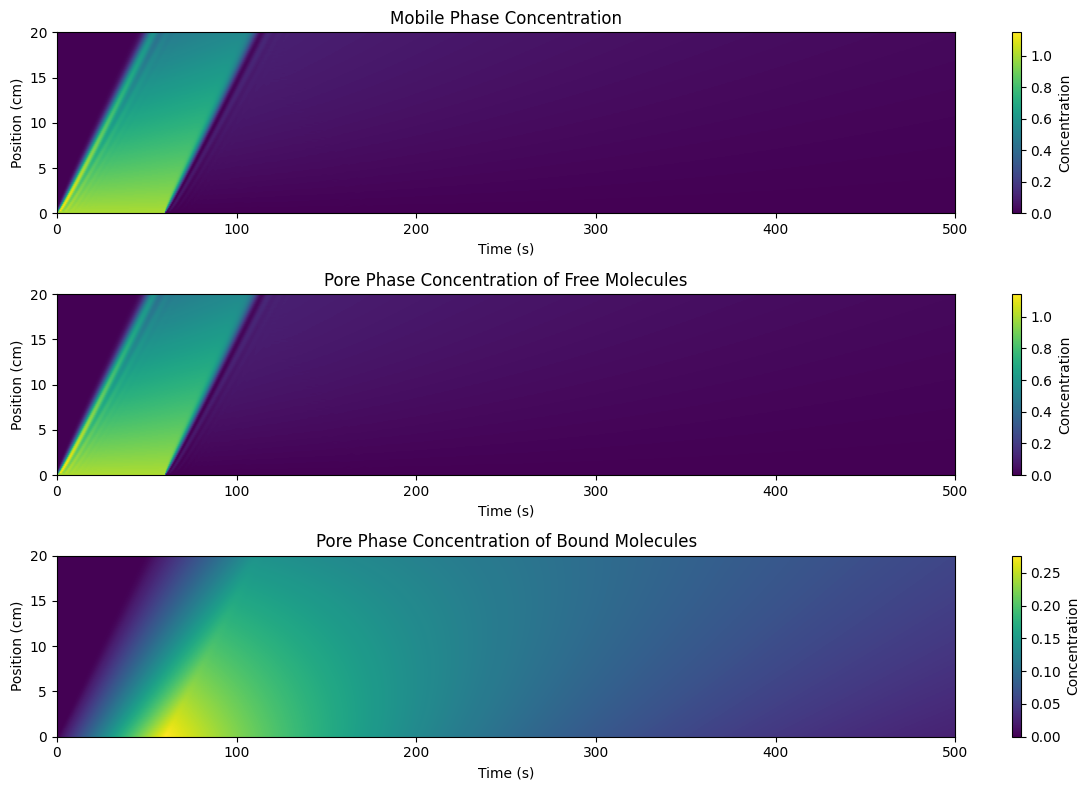

Final bound concentration: 4.333358203039171


In [ ]:
class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, filter_size, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size):
        super().__init__(feed=None, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = molecule_size  # for the ligand density
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = affinity  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = pI   # point isoélectrique de la molécule

        self.z = np.linspace(0, L, Nx)
        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant
        :return: coefficient de diffusion ajusté.
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
        :return: facteur d'affinité ajusté.
        """
        if abs(self.pH - self.pI) < 1:
            charge_effect = 0.2  # Molécule partiellement neutre
        elif self.pH > self.pI:
            charge_effect = 0.8  # Molécule négative
        else:
            charge_effect = 0.8  # Molécule positive
        affinity_base = self.affinity * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity))
        return affinity_ #* charge_effect


    def calculate_R(self, c, cp, q):
        """
        Calcule le taux de transport R pour la phase mobile
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q):
        """
        Calcule le taux de transport des free molecules Rp pour la phase libre dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rp.
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp)
        rq = self.calculate_rq(cp, q)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q):
        """
        Calcule le taux de transport des molécules liées Rq pour la phase liée dans les pores.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction Rq.
        """
        rq = self.calculate_rq(cp, q)
        return rq

    def calculate_rp(self, c, cp):
        """
        Calcule le terme de réaction rp pour la phase mobile.
        :param c: concentration de la phase mobile.
        :param cp: concentration dans les pores de la phase libre.
        :return: terme de réaction rp.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (c - cp)

    def calculate_rq(self, cp, q):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores.
        :param cp: concentration dans les pores de la phase libre.
        :param q: concentration dans les pores de la phase liée.
        :return: terme de réaction rq.
        """
        affinity_factor = self.calculate_affinity_factor()
        return affinity_factor * (cp - q)

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse.
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.calculate_R(self.c, self.cp, self.q)
            dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
            dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

            # Ensure no overflow or invalid values
            self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
            self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
            self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())


    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.tight_layout()
        plt.show()

    def get_final_bound_concentration(self):
        """
        Retourne la concentration totale des molécules cibles qui sont restées accrochées dans la colonne.
        """
        return np.sum(self.q)

    def calculate_mass_recovered(self):
        """
        Calcule la masse totale des molécules cibles récupérées dans la colonne.
        """
        mass_recovered = np.trapz(self.q, dx=self.dx)
        return mass_recovered

    def get_yield(self):
        """
        Calcule le rendement du processus de chromatographie en comparant la masse récupérée à la masse injectée.
        """
        mass_recovered = self.calculate_mass_recovered()
        mass_injected = self.pulse_concentration * self.pulse_duration * self.v
        return mass_recovered / mass_injected


# Example usage:

feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 500.0
v = 0.1
D = 0.01
Nx = 100
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.3
ligand_density = 0.7

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=pulse_concentration,
    feed=feed,
    filter_size=filter_size,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=affinity,
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI = pI,
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=molecule_size
)

chromato.perform_chromatography()
chromato.plot_result()
final_bound_concentration = chromato.get_final_bound_concentration()
print("Final bound concentration:", final_bound_concentration)


question
quelle difference entre la chroma par taille (avec bille de gel) et filtrage par tamissage

Se rapprocher le plus possible de l'affinité optiamale (ou en tout cas obtenir une équations la plus juste possible) pour ensuite partir de ce point initiale pour
    # lancer l'apprentissage
    #chaque para à une influence sur l'affinité, la densité de ligand dépend de "l'encombrement sphérique" => molecule_size, la conductivité, le pH qui influe la structure 3D de la molécule et donc de sa charge """effective"""
    # Globalement si le pH > point iso éléctrique + 1, alors la protéine est chargée positivement (à 80%). Si le pH < point i.e. - 1 la protéiné est considérée comme négative (à 80%)
    #
    

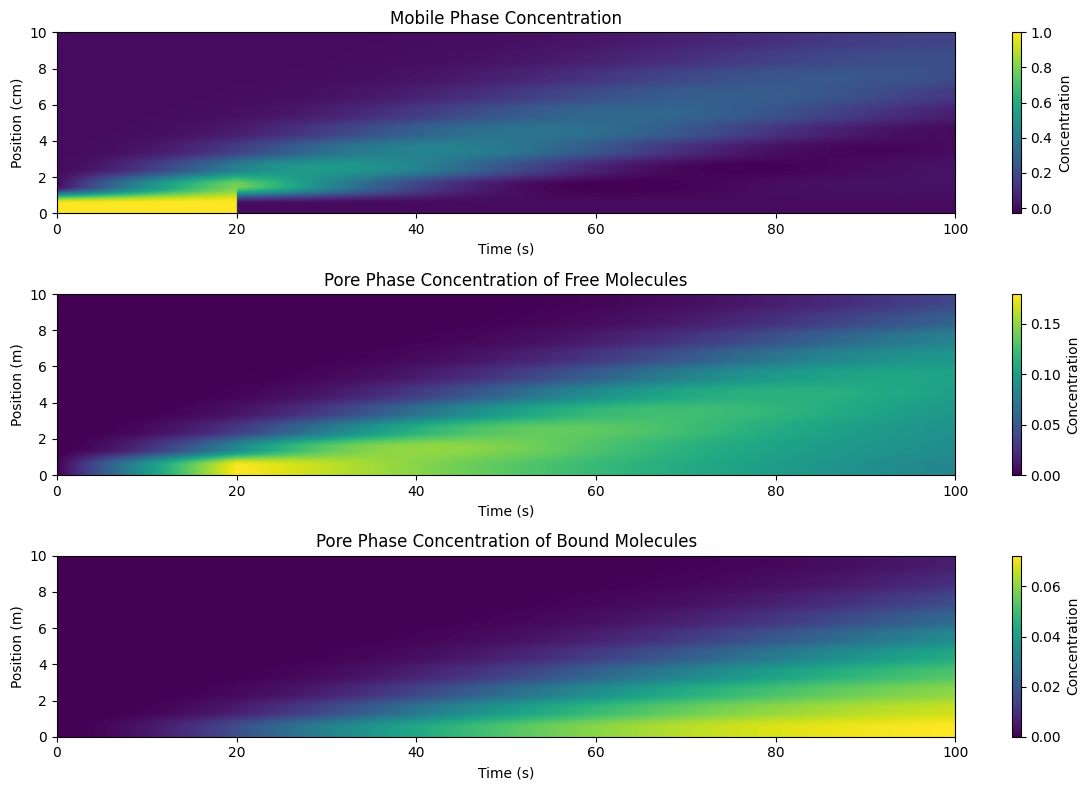

In [ ]:
## Filtration baséée sur la taille de la molécule

class Filtration:
    def __init__(self, feed, filter_size):
        self.feed = feed
        self.filter_size = filter_size

class Chromatography(Filtration):
    def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity):
        super().__init__(feed, filter_size)

        self.L = L # longueur de la colonne (cm)
        self.T = T # temps de la chromatographie
        self.v = v # velocité linéaire de la phase mobile (m/s)
        self.D = D # coefficient de diffusion  (m^2/s)
        self.Nx = Nx # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration # durée d'alimentation
        self.pulse_concentration = pulse_concentration # concentration de l'alimentation
        self.target_molecule = target_molecule # molécule d'interêt
        self.particle_size = particle_size
        self.molecule_size = molecule_size
        self.temperature = temperature
        self.solvent_viscosity = solvent_viscosity
        self.affinity = affinity

        self.z = np.linspace(0, L, Nx)

        self.c = np.zeros(Nx)
        self.cp = np.zeros(Nx)
        self.q = np.zeros(Nx)

        self.c0 = lambda z: np.zeros_like(z)
        self.cp0 = lambda z: np.zeros_like(z)
        self.q0 = lambda z: np.zeros_like(z)

        self.apply_initial_conditions()

        # Transport and production rates
        self.R = self.calculate_R
        self.Rp = self.calculate_Rp
        self.Rq = self.calculate_Rq

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp.copy()]
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        return self.D * (self.temperature / 298.15) * (1.0 / self.solvent_viscosity)

    def calculate_R(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rp(self, c, cp, q):
        return self.affinity * (c - cp) * (self.particle_size / (self.particle_size + self.molecule_size))

    def calculate_Rq(self, c, cp, q):
        return self.affinity * (cp - q) * (self.particle_size / (self.particle_size + self.molecule_size))

    def perform_chromatography(self):
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx)
            N = self.v * self.c + J

            dc_dt = -np.gradient(N, self.dx) - self.R(self.c, self.cp, self.q)
            dcp_dt = self.Rp(self.c, self.cp, self.q)
            dq_dt = self.Rq(self.c, self.cp, self.q)

            self.c += dc_dt * self.dt
            self.cp += dcp_dt * self.dt
            self.q += dq_dt * self.dt

            if t <= self.pulse_duration:
                self.c[0] = self.pulse_concentration
            else:
                self.c[0] = 0.0


            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp.copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        c_history = np.array(self.c_history)
        cp_history = np.array(self.cp_history)
        q_history = np.array(self.q_history)

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.title('Mobile Phase Concentration')
        plt.imshow(c_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        plt.subplot(3, 1, 2)
        plt.title('Pore Phase Concentration of Free Molecules')
        plt.imshow(cp_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(3, 1, 3)
        plt.title('Pore Phase Concentration of Bound Molecules')
        plt.imshow(q_history.T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

    def plot_results(self,nbr_simu):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()


# Parameters
L = 10
T = 100.0
v = 0.1
D = 0.01
Nx = 10
Nt = 10000
pulse_duration = 20
pulse_concentration = 1
target_molecule = 'A'
feed = [{'type': 'A', 'concentration': 1.0}, {'type': 'B', 'concentration': 0.5}]
filter_size = 1.0
particle_size = .01  # Example particle size
molecule_size = 0.0001  # Example molecule size
temperature = 298.15  # Example temperature in Kelvin (25°C)
solvent_viscosity = 1  # Example solvent viscosity (arbitrary units)
affinity = 0.01  # Example affinity constant
size = [.0001,.001,.01]

# Instantiate and run chromatography
chromatography = Chromatography(L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, target_molecule, feed, filter_size, particle_size, molecule_size, temperature, solvent_viscosity, affinity)
chromatography.perform_chromatography()
chromatography.plot_result()

Simulation progress: 0.0%
Simulation time: 0.0s
Phys time: 0.06844472885131836s
Simulation progress: 10.0%
Simulation time: 3.0s
Phys time: 13.182373046875s
Simulation progress: 20.0%
Simulation time: 6.0s
Phys time: 19.55939745903015s
Simulation progress: 30.0%
Simulation time: 9.0s
Phys time: 24.024834394454956s
Simulation progress: 40.0%
Simulation time: 12.0s
Phys time: 31.592766046524048s
Simulation progress: 50.0%
Simulation time: 15.0s
Phys time: 36.11041760444641s
Simulation progress: 60.0%
Simulation time: 18.0s
Phys time: 42.699464559555054s
Simulation progress: 70.0%
Simulation time: 21.0s
Phys time: 46.97693729400635s
Simulation progress: 80.0%
Simulation time: 24.0s
Phys time: 51.21340322494507s
Simulation progress: 90.0%
Simulation time: 27.0s
Phys time: 57.72941541671753s
Total Computaion time: 62.22264790534973


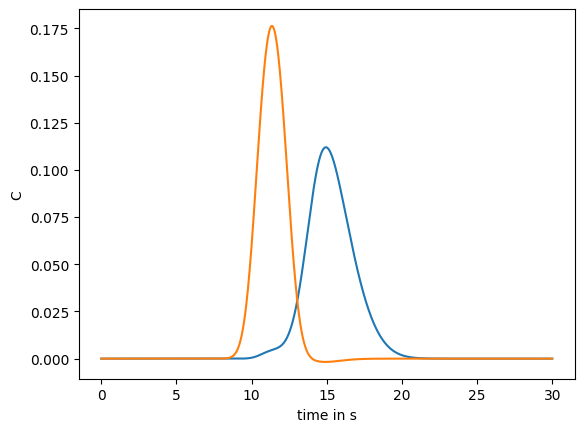

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 15 18:32:32 2020

@author: Benedict
"""

# -*- coding: utf-8 -*-
"""
Created on Sat Aug 15 17:15:14 2020

@author: Benedict
"""

import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import time
#column Parameters
L = 15 #cm
tmax = 30 #s
u_inter = 1.5 #cm/s
epsilon = 0.72
t_slug=2
keff=0.01
Rp=0.0025
Lambda=2

const_1 = (1-epsilon)/epsilon#constants to reduce computations
const_2 = 3/Rp #constants to reduce computations
D_ax = 0.05 #cm^2/s

#Numeric Parameters
dt = 0.005 #s
dx = 0.1 #cm
N=int(L/dx)
M=int(tmax/dt)


#Components
isotherme='Langmuir'
C=2 # Number of Components
params=np.ndarray(C,dict)

if isotherme=='Langmuir':
    params[0]={'KL': 1,'qmax': 0.5,'c_in':0.2}
    params[1]={'KL': 0.1,'qmax': 0.5,'c_in':0.2}

if isotherme=='Henry':
    params[0]={'Kh': 1,'c_in':1}
    params[1]={'Kh': 0.1,'c_in':1}

if isotherme=='SMA':
    params[0]={'Ksma': 3,'sigma':2,'ny':2,'c_in':2}
    params[1]={'Ksma': 1,'sigma':4,'ny':3,'c_in':2}

#Memory
concentration=np.zeros((C,N))
q=np.zeros((C,N))
if isotherme=='SMA':
    c_salt=np.zeros(N)
    c_salt_save = np.zeros(N)
concentration_s=np.zeros((C,N))
q_s=np.zeros((C,N))

#visualiation
plot=np.zeros((C,M))
t=[i*dt for i in range(M)]
def compute_dc_dx(c_i,i):
    return (c_i[i+1]-c_i[i-1])/(2*dx)

def compute_dc2_dx2(c_i,i):
    return (c_i[i+1]+c_i[i-1]-2*c_i[i])/(dx*dx)

def compute_cp_LG(c,q,i,params):
    A=np.ndarray((C,C))
    D=np.ndarray(C)

    for k in range(C):
        for l in range(C):
            if k==l:
                A[k][l] = params[l]['KL']*(q[k][i]-params[l]['qmax'])
            else:
                A[k][l]=q[k][i]*params[l]['KL']
        D[k]=-q[k][i]
    return D.dot(np.linalg.inv(A))

def compute_cp_SMA(q,k,i,params,csalt):
    tmp=0
    for r in range(C):
        tmp+=q[r][i]*(params[r]['ny']+params[r]['sigma'])
    return (q[k][i]/params[k]['Ksma'])*(csalt/(Lambda-tmp))**params[k]['ny']

#Main Computation

if __name__=='__main__':
    start=time.time()
    #Initial conditions
    for k in range(C):
        concentration[k][0]=params[k]['c_in']
    if isotherme=='SMA':
        c_salt[0]=1

    #Main Looper
    for i in range(M):
       concentration_s=cp.deepcopy(concentration)
       q_s=cp.deepcopy(q)

       if isotherme=='SMA':
           c_salt_save = cp.deepcopy(c_salt)

       if isotherme=='Langmuir':
           for l in range(1,N-1):
               tmp=compute_cp_LG(concentration_s,q_s,l,params)
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-tmp[k]))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-tmp[k])*dt

       if isotherme=='Henry':
           for l in range(1,N-1):
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-q[k][l]/params[k]['Kh']))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-q[k][l]/params[k]['Kh'])*dt

       if isotherme=='SMA':
           for l in range(1,N-1):
               c_salt[l]+=(D_ax*compute_dc2_dx2(c_salt_save,l)-u_inter*compute_dc_dx(c_salt_save,l))*dt
               for k in range(C):
                   concentration[k][l]+=(D_ax*compute_dc2_dx2(concentration_s[k],l)-u_inter*compute_dc_dx(concentration_s[k],l)-const_1*const_2*keff*(concentration_s[k][l]-compute_cp_SMA(q,k,l,params,c_salt[l])))*dt
                   q[k][l]+=const_1*const_2*keff*(concentration_s[k][l]-compute_cp_SMA(q,k,l,params,c_salt[l]))*dt

        #boundary conditions
       for k in range(C):
           if i*dt<t_slug:
               concentration[k][0]=params[k]['c_in']
           else:
               concentration[k][0]=0
           concentration[k][-1]=concentration[k][-2]
       if isotherme=='SMA':
           c_salt[-1]=c_salt[-2]

        #add detecotor output for visualization
       for k in range(C):
           plot[k][i]=concentration[k][-2]
       if 100*i/M%10==0:
        print('Simulation progress: '+str(100*i/M)+'%')
        print('Simulation time: '+str(i*dt)+'s')
        print('Phys time: '+str(time.time()-start)+'s')

    print('Total Computaion time: '+str(time.time()-start))
    #visualization
    plt.xlabel('time in s')
    plt.ylabel('C')
    for k in range(C):
        plt.plot(t,plot[k,:])



In [ ]:
import numpy as np

class Chromatography(Filtration):

    def __init__(self, L, T, v, D, Nx,Nr, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                 affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size, elution_volume, n_components=1):

        super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

        self.L = L  # longueur de la colonne (cm)
        self.T = T  # temps de la chromatographie
        self.v = v  # vitesse linéaire de la phase mobile (m/s)
        self.D = D  # coefficient de diffusion (m^2/s)
        self.Nx = Nx  # discrétisation spatiale
        self.Nt = Nt  # discrétisation temporelle
        self.Nr = Nr
        self.dx = L / Nx
        self.dt = T / Nt
        self.pulse_duration = pulse_duration  # durée d'alimentation
        self.pulse_concentration = np.array(pulse_concentration)  # concentration de l'alimentation
        self.particle_size = particle_size  # taille des particules
        self.molecule_size = np.array(molecule_size)  # taille des molécules
        self.temperature = temperature  # température (Kelvin)
        self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
        self.affinity = np.array(affinity)  # constante d'affinité
        self.epsilon_c = epsilon_c  # porosité de la colonne
        self.epsilon_p = epsilon_p  # porosité des particules
        self.pH = pH  # pH du solvant
        self.conductivity = conductivity  # conductivité du solvant
        self.ligand_density = ligand_density  # densité de ligand
        self.pI = np.array(pI)  # point isoélectrique des molécules
        self.elution_volume = elution_volume
        self.n_components = n_components  # Nombre de composants

        # Discrétisation spatiale et radiale
        self.z = np.linspace(0, L, Nx)
        self.r = np.linspace(0, particle_size / 2, Nr)  # Radial discretization
        self.dr = self.r[1] - self.r[0]

        # Concentrations dans les phases mobile, dans les pores et liée
        self.c = np.zeros((Nx, n_components))
        self.cp = np.zeros((Nx,Nr, n_components))
        self.q = np.zeros((Nx, n_components))

        # Conditions initiales
        self.c0 = lambda z: np.zeros((len(z), n_components))
        self.cp0 = lambda z: np.zeros((len(z), len(z), n_components))
        self.q0 = lambda z: np.zeros((len(z), n_components))

        self.apply_initial_conditions()

        self.c_history = [self.c.copy()]
        self.cp_history = [self.cp[:, -1, :].copy()]  # Stocke uniquement la concentration au centre des particules
        self.q_history = [self.q.copy()]

    def apply_initial_conditions(self):
        self.c = self.c0(self.z)
        self.cp = self.cp0(self.z)
        self.q = self.q0(self.z)

    def calculate_diffusion_coefficient(self):
        """
        Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
        Formule dérivée de la loi de Stijes-Einstein
        """
        return self.D * (self.temperature / 298.15) / self.solvent_viscosity

    def calculate_open_surface_area_per_volume(self):
        """
        Calcule la surface ouverte par volume de liquide pour les particules
        """
        return 6 / self.particle_size

    def calculate_open_pore_surface_area_per_volume(self):
        """
        Calcule la surface ouverte des pores par volume de pores
        """
        return 6 / self.particle_size

    def get_max_ligand_density(self):
        """
        Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
        """
        ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
        surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
        max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
        return max_ligand_density

    def calculate_affinity_factor(self, i):
        """
        Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand pour un composant donné
        :param i: index du composant
        :return: facteur d'affinité ajusté.
        """
        affinity_base = self.affinity[i] * np.exp(-abs(7.5 - self.pH))
        ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
        charge_effect = 1 if abs(self.pH - self.pI[i]) < 1 else 0.8
        affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
        return affinity_

    def calculate_R(self, c, cp, q, i):
        """
        Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction R
        """
        phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
        rp = self.calculate_rp(c, cp, i)
        return -phi_l * rp

    def calculate_Rp(self, c, cp, q, i):
        """
        Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
        Représente les molécules entrant ou sortant de l'espace poreux où elles ne sont pas liées à la phase stationnaire
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction Rp
        """
        phi_p = self.calculate_open_pore_surface_area_per_volume()
        rp = self.calculate_rp(c, cp, i)
        rq = self.calculate_rq(cp, q, i)
        return phi_p * rp + rq

    def calculate_Rq(self, c, cp, q, i):
        """
        Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
        Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
        :param c: concentration de la phase mobile
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction Rq
        """
        rq = self.calculate_rq(cp, q, i)
        return rq

   def calculate_rp(self, c, cp, i):
      """
      Calcule le terme de réaction rp pour la phase mobile
      :param c: concentration de la phase mobile.
      :param cp: concentration dans les pores de la phase libre
      :param i: index du composant
      :return: terme de réaction rp
      """
      affinity_factor = self.calculate_affinity_factor(i)
      return affinity_factor * (c[:, i] - cp[:, :, i].mean(axis=1))


    def calculate_rq(self, cp, q, i):
        """
        Calcule le terme de réaction rq pour la phase liée dans les pores
        :param cp: concentration dans les pores de la phase libre
        :param q: concentration dans les pores de la phase liée
        :param i: index du composant
        :return: terme de réaction rq
        """
        affinity_factor = self.calculate_affinity_factor(i)
        return affinity_factor * (cp[:, 0, i] - q[:, i])  # Utilisation de cp[:, 0, i] pour compatibilité dimensionnelle

    def perform_chromatography(self):
        """
        Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
        """
        for n in range(self.Nt):
            t = n * self.dt
            D_eff = self.calculate_diffusion_coefficient()
            J = -D_eff * np.gradient(self.c, self.dx, axis=0)
            N = self.v * self.c + J

            for i in range(self.n_components):
                dc_dt = -np.gradient(N[:, i], self.dx) - self.calculate_R(self.c, self.cp, self.q, i)
                dcp_dt = self.calculate_Rp(self.c, self.cp, self.q, i)
                dq_dt = self.calculate_Rq(self.c, self.cp, self.q, i)

                # Mise à jour des concentrations
                self.c[:, i] = np.clip(self.c[:, i] + dc_dt * self.dt, 0, np.inf)
                self.cp[:, :, i] = np.clip(self.cp[:, :, i] + dcp_dt[:, None] * self.dt, 0, np.inf)
                self.q[:, i] = np.clip(self.q[:, i] + dq_dt * self.dt, 0, np.inf)

            if t <= self.pulse_duration:
                self.c[0, :] = self.pulse_concentration
            else:
                self.c[0, :] = 0.0

            self.c_history.append(self.c.copy())
            self.cp_history.append(self.cp[:, -1, :].copy())
            self.q_history.append(self.q.copy())

    def plot_result(self):
        time_points = np.linspace(0, self.T, len(self.c_history))

        size  = self.molecule_size * i * 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.title(f'Mobile Phase Concentration for molecule size {size}')
        plt.imshow(np.array(self.c_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.subplot(2, 1, 2)
        plt.title(f'Pore Phase Concentration of Free molecule size {self.charges[i]}')
        plt.imshow(np.array(self.cp_history)[:, i, :].T, aspect='auto', origin='lower', extent=[0, self.T, 0, self.L])
        plt.colorbar(label='Concentration')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')

        plt.tight_layout()
        plt.show()

n_components = 3  # Par exemple, pour trois différents solutés


feed = feed_initial
filter_size = 1.0

particle_size = 0.005
molecule_size = 0.001
L = 20
T = 300.0
v = 0.1
D = 0.000001
Nx = 1000
Nr = 30
Nt = 10000
pulse_duration = 60
pulse_concentration = 1
temperature = 293.15
solvent_viscosity = 0.5
affinity = 0.01
epsilon_c = 0.4
epsilon_p = 0.5
pH = 7.5
pI = 7.5
conductivity = 0.5
ligand_density = 0.7

chromato = Chromatography(
    L=L,
    T=T,
    v=v,
    D=D,
    Nx=Nx,
    Nr = Nr,
    Nt=Nt,
    pulse_duration=pulse_duration,
    pulse_concentration=[1, 0.5, 0.3],  # Différentes concentrations pour chaque composant
    feed=feed,
    particle_size=particle_size,
    temperature=temperature,
    solvent_viscosity=solvent_viscosity,
    affinity=[0.01, 0.02, 0.03],  # Différentes affinités pour chaque composant
    epsilon_c=epsilon_c,
    epsilon_p=epsilon_p,
    pH=pH,
    pI=[7.5, 6.5, 8.0],  # Différents points isoélectriques pour chaque composant
    conductivity=conductivity,
    ligand_density=ligand_density,
    molecule_size=[0.001, 0.0015, 0.002],  # Différentes tailles de molécules
    elution_volume=elution_volume,
    n_components=n_components  # Ajout de l'argument n_components
)

chromato.perform_chromatography()
chromato.plot_result()


ValueError: operands could not be broadcast together with shapes (3,) (1000,) 

In [ ]:
  import numpy as np
  import matplotlib.pyplot as plt

  class ChromatographyGRM(Filtration):

      def __init__(self, L, T, v, D, Nx, Nt, pulse_duration, pulse_concentration, feed, particle_size, temperature, solvent_viscosity,
                  affinity, epsilon_c, epsilon_p, pH, pI, conductivity, ligand_density, molecule_size, elution_volume, n_components):

          super().__init__(feed=feed, filter_size=None, type_filtration='chromatography', filter_charge=None, flow_rate=v, pressure=None, temperature=temperature)

          self.L = L  # longueur de la colonne (cm)
          self.T = T  # temps de la chromatographie
          self.v = v  # vitesse linéaire de la phase mobile (m/s)
          self.D = D  # coefficient de diffusion (m^2/s)
          self.Nx = Nx  # discrétisation spatiale
          self.Nt = Nt  # discrétisation temporelle
          self.dx = L / Nx
          self.dt = T / Nt
          self.pulse_duration = pulse_duration  # durée d'alimentation
          self.pulse_concentration = pulse_concentration  # concentration de l'alimentation
          self.particle_size = particle_size  # taille des particules
          self.molecule_size = molecule_size  # to help determine the opti ligand density
          self.temperature = temperature  # température (Kelvin)
          self.solvent_viscosity = solvent_viscosity  # viscosité du solvant
          self.affinity = affinity  # constante d'affinité
          self.epsilon_c = epsilon_c  # porosité de la colonne
          self.epsilon_p = epsilon_p  # porosité des particules
          self.pH = pH  # pH du solvant
          self.conductivity = conductivity  # conductivité du solvant
          self.ligand_density = ligand_density  # densité de ligand
          self.pI = pI   # point isoélectrique de la molécule
          self.elution_volume = elution_volume

          # Ajout pour multi-composants
          self.n_components = n_components
          self.z = np.linspace(0, L, Nx)
          self.c = np.zeros((n_components, Nx))
          self.cp = np.zeros((n_components, Nx))
          self.q = np.zeros((n_components, Nx))

          self.c0 = lambda z: np.zeros_like(z)
          self.cp0 = lambda z: np.zeros_like(z)
          self.q0 = lambda z: np.zeros_like(z)

          self.apply_initial_conditions()

          self.c_history = [self.c.copy()]
          self.cp_history = [self.cp.copy()]
          self.q_history = [self.q.copy()]

      def apply_initial_conditions(self):
          self.c = np.array([self.c0(self.z) for _ in range(self.n_components)])
          self.cp = np.array([self.cp0(self.z) for _ in range(self.n_components)])
          self.q = np.array([self.q0(self.z) for _ in range(self.n_components)])

      def calculate_diffusion_coefficient(self):
          """
          Calcule le coefficient de diffusion de Fick effectif en fonction de la température et de la viscosité du solvant ainsi que de la taille de la molécule
          Formule dérivée de la loi de Stijes-Einstein
          """
          return self.D * (self.temperature / 298.15) / self.solvent_viscosity

      def calculate_open_surface_area_per_volume(self):
          """
          Calcule la surface ouverte par volume de liquide pour les particules
          """
          return 6 / self.particle_size

      def calculate_open_pore_surface_area_per_volume(self):
          """
          Calcule la surface ouverte des pores par volume de pores
          """
          return 6 / self.particle_size

      def get_max_ligand_density(self):
          """
          Calcule la densité maximale de ligand en tenant compte de la taille des ligands et de la surface spécifique de la résine
          """
          ligand_area = np.pi * (self.molecule_size / 2) ** 2  # surface d'un ligand
          surface_per_volume = self.calculate_open_surface_area_per_volume()  # surface spécifique de la résine
          max_ligand_density = surface_per_volume / ligand_area  # densité maximale de ligand
          return max_ligand_density

      def calculate_affinity_factor(self, component_index):
          """
          Calcule le facteur d'affinité ajusté en fonction du pH, de la conductivité et de la densité de ligand
          :param component_index: l'indice du composant pour lequel l'affinité est calculée
          :return: facteur d'affinité ajusté.
          """
          affinity_base = self.affinity[component_index] * np.exp(-abs(7.5 - self.pH))
          ligand_effect = self.ligand_density / (1 + self.ligand_density / self.get_max_ligand_density())
          charge_effect = 1 if abs(self.pH - self.pI[component_index]) < 1 else 0.8
          affinity_ = affinity_base * ligand_effect * (1 / (1 + self.conductivity)) * charge_effect
          return affinity_

      def calculate_R(self, c, cp, q):
          """
          Calcule le taux de transport du volume de liquide mobile (bulk phase) au volume des pores des particules
          pour tous les composants
          :param c: concentration de la phase mobile pour tous les composants
          :param cp: concentration dans les pores de la phase libre pour tous les composants
          :param q: concentration dans les pores de la phase liée pour tous les composants
          :return: terme de réaction R pour tous les composants
          """
          phi_l = (1 - self.epsilon_c) * self.calculate_open_surface_area_per_volume() * self.epsilon_p / self.epsilon_c
          rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(self.n_components)])
          return -phi_l * rp

      def calculate_Rp(self, c, cp, q):
          """
          Calcule le taux de transport des molécules dans le volume libre (unbound ou free) à l'intérieur des pores des particules
          pour tous les composants
          :param c: concentration de la phase mobile pour tous les composants
          :param cp: concentration dans les pores de la phase libre pour tous les composants
          :param q: concentration dans les pores de la phase liée pour tous les composants
          :return: terme de réaction Rp pour tous les composants
          """
          phi_p = self.calculate_open_pore_surface_area_per_volume()
          rp = np.array([self.calculate_rp(c[i], cp[i], i) for i in range(self.n_components)])
          rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(self.n_components)])
          return phi_p * rp + rq

      def calculate_Rq(self, c, cp, q):
          """
          Calcule le taux de transport des molécules vers l'état lié dans le volume des pores de la particule.
          => Correspond à l'adsorption (ou à la désorption) des molécules sur (ou depuis) ​​les ligands dans les pores de la particule
          pour tous les composants
          :param c: concentration de la phase mobile pour tous les composants
          :param cp: concentration dans les pores de la phase libre pour tous les composants
          :param q: concentration dans les pores de la phase liée pour tous les composants
          :return: terme de réaction Rq pour tous les composants
          """
          rq = np.array([self.calculate_rq(cp[i], q[i], i) for i in range(self.n_components)])
          return rq

      def calculate_rp(self, c, cp, component_index):
          """
          Calcule le terme de réaction rp pour la phase mobile
          :param c: concentration de la phase mobile.
          :param cp: concentration dans les pores de la phase libre
          :param component_index: l'indice du composant pour lequel rp est calculé
          :return: terme de réaction rp
          """
          affinity_factor = self.calculate_affinity_factor(component_index)
          return affinity_factor * (c - cp)

      def calculate_rq(self, cp, q, component_index):
          """
          Calcule le terme de réaction rq pour la phase liée dans les pores
          :param cp: concentration dans les pores de la phase libre
          :param q: concentration dans les pores de la phase liée
          :param component_index: l'indice du composant pour lequel rq est calculé
          :return: terme de réaction rq
          """
          affinity_factor = self.calculate_affinity_factor(component_index)
          return affinity_factor * (cp - q)

      def perform_chromatography(self):
          """
          Effectue la simulation de la chromatographie en résolvant les équations de transfert de masse
          pour tous les composants
          """
          for n in range(self.Nt):
              t = n * self.dt
              D_eff = self.calculate_diffusion_coefficient()
              J = -D_eff * np.gradient(self.c, self.dx, axis=1)
              N = self.v * self.c + J

              dc_dt = -np.gradient(N, self.dx, axis=1) - self.calculate_R(self.c, self.cp, self.q)
              dcp_dt = self.calculate_Rp(self.c, self.cp, self.q)
              dq_dt = self.calculate_Rq(self.c, self.cp, self.q)

              # Ensure no overflow or invalid values
              self.c = np.clip(self.c + dc_dt * self.dt, 0, np.inf)
              self.cp = np.clip(self.cp + dcp_dt * self.dt, 0, np.inf)
              self.q = np.clip(self.q + dq_dt * self.dt, 0, np.inf)

              if t <= self.pulse_duration:
                  self.c[:, 0] = self.pulse_concentration
              else:
                  self.c[:, 0] = 0.0

              self.c_history.append(self.c.copy())
              self.cp_history.append(self.cp.copy())
              self.q_history.append(self.q.copy())

      # Ajoutez d'autres méthodes pour analyser les résultats (pureté, rendement, etc.)

  # Exemple d'utilisation
  feed = feed_initial

  particle_size = 0.005
  molecule_size = 0.001
  L = 20
  T = 300.0
  v = 0.1
  D = 0.01
  Nx = 1000
  Nt = 10000
  pulse_duration = 60
  pulse_concentration = 1
  temperature = 293.15
  solvent_viscosity = 0.5
  affinity = [0.01, 0.005]  # Affinités pour deux composants
  epsilon_c = 0.4
  epsilon_p = 0.5
  pH = 7.5
  pI = [7.5, 6.5]  # Points isoélectriques pour deux composants
  conductivity = 0.5
  ligand_density = 0.7
  elution_volume = 1  # L

  chromato = ChromatographyGRM(
      L=L,
      T=T,
      v=v,
      D=D,
      Nx=Nx,
      Nt=Nt,
      pulse_duration=pulse_duration,
      pulse_concentration=pulse_concentration,
      feed=feed,
      particle_size=particle_size,
      temperature=temperature,
      solvent_viscosity=solvent_viscosity,
      affinity=affinity,
      epsilon_c=epsilon_c,
      epsilon_p=epsilon_p,
      pH=pH,
      pI=pI,
      conductivity=conductivity,
      ligand_density=ligand_density,
      molecule_size=molecule_size,
      elution_volume=elution_volume,
      n_components=2  # Nombre de composants
  )

  chromato.perform_chromatography()
  chromato.plot_result()  # Cette méthode devra être modifiée pour gérer les résultats multi-composants


AttributeError: 'ChromatographyGRM' object has no attribute 'plot_result'

##CADET

In [24]:
!pip install cadet

In [25]:
import numpy as np
from cadet import Cadet

In [33]:
# -*- coding: utf-8 -*-
"""
This script contains the CADET simulation code for
the 3 component step elution CADET model.

CADET License: https://cadet.github.io/v4.3.0/license.html

This script is the front-end for the CADET simulation software

Copyright (C) 2008-2022: The CADET Authors
           Please see the AUTHORS and CONTRIBUTORS file.

All rights reserved. This program and the accompanying materials
are made available under the terms of the GNU Public License v3.0 (or, at
your option, any later version) which accompanies this distribution, and
is available at http://www.gnu.org/licenses/gpl.html
"""
import platform
from cadet import Cadet
import numpy as np


def run_cadet_sim(ms):

   cadet_bin_path = ms['cadet_bin_path']

   if platform.system() == 'Windows':
       cadet_path = cadet_bin_path / 'cadet-cli.exe'
       lwe_path = cadet_bin_path / 'createLWE.exe'

   else:
        cadet_path = cadet_bin_path / 'cadet-cli'
        lwe_path = cadet_bin_path / 'createLWE'

   if cadet_path.exists() and lwe_path.exists():
       Cadet.cadet_path = cadet_path.as_posix()
   elif cadet_path.exists() and not lwe_path.exists():
       print('CADET was found but createLWE.exe was not found. Please make sure that none of the files have been moved.')
   else:
       print('CADET could not be found. Please check the bin path')

   print('\nSimulation Running!\n')

   # Create model object
   model = Cadet()

   # Number of unit operations
   model.root.input.model.nunits = 4

   # Inlet for SMA ############################################################
   model.root.input.model.unit_000.unit_type = 'INLET'
   model.root.input.model.unit_000.ncomp = len(ms['feed_conc_mM']) + 1
   model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

   # Inlet sections
   # Section 1: Loading phase
   model.root.input.model.unit_000.sec_000.const_coeff = [ms['load_salt']] + ms['feed_conc_mM'] # [mol / m^3] = [mM]
   model.root.input.model.unit_000.sec_000.lin_coeff = [0] + [0 for c in ms['feed_conc']]
   model.root.input.model.unit_000.sec_000.quad_coeff = [0] + [0 for c in ms['feed_conc']]
   model.root.input.model.unit_000.sec_000.cube_coeff = [0] + [0 for c in ms['feed_conc']]

   # Section 2: Washing phase [no protein feed]
   model.root.input.model.unit_000.sec_001.const_coeff = [ms['wash_salt']] + [0 for c in ms['feed_conc']] # [mol / m^3] component 1, component 2

   # Section 3: step 1
   model.root.input.model.unit_000.sec_002.const_coeff = [ms['step1_salt']] + [0 for c in ms['feed_conc']] # [mol / m^3] component 1, component 2

   # Section 4: step 2
   model.root.input.model.unit_000.sec_003.const_coeff = [ms['step2_salt']] + [0 for c in ms['feed_conc']] # [mol / m^3] component 1, component 2

   # Section 5: step 3
   model.root.input.model.unit_000.sec_004.const_coeff = [ms['step3_salt']] + [0 for c in ms['feed_conc']] # [mol / m^3] component 1, component 2

   ## Construct CSTR (mixer) unit operation (tank model) ######################
   model.root.input.model.unit_001.unit_type = 'CSTR'
   model.root.input.model.unit_001.ncomp = len(ms['feed_conc_mM']) + 1

   model.root.input.model.unit_001.init_c = [ms['load_salt']] + [0 for c in ms['feed_conc']] # [mol / m^3], Initial concentrations for each component in liquid phase
   model.root.input.model.unit_001.init_q = [] # [mol / m^3], Initial concentrations for each component in solid phase

   model.root.input.model.unit_001.init_volume = 1e-6 # CSTR volume in [m^3]

   # General Rate Model #######################################################
   model.root.input.model.unit_002.unit_type = 'GENERAL_RATE_MODEL'

   model.root.input.model.unit_002.ncomp = len(ms['feed_conc_mM']) + 1

   ## Geometry
   model.root.input.model.unit_002.col_length = ms['col_length']                       # m
   model.root.input.model.unit_002.cross_section_area = ms['Ac_col']                   # m
   model.root.input.model.unit_002.col_porosity = ms['Ee']                             # -
   model.root.input.model.unit_002.par_porosity = ms['Ep']                             # -
   model.root.input.model.unit_002.par_radius = 0.5*ms['particle_diameter']            # m

   ## Transport
   model.root.input.model.unit_002.col_dispersion = ms['Dax_col'] # m^2 / s (interstitial volume)
   model.root.input.model.unit_002.film_diffusion = ms['k_film'] # m / s
   model.root.input.model.unit_002.par_diffusion = [ms['salt_pore_diff']] + list(ms['pore_diff']) # m^2 / s (mobile phase)

   model.root.input.model.unit_002.adsorption.is_kinetic = True    # Kinetic binding

   ## Isotherm ################################################################
   model.root.input.model.unit_002.adsorption_model = 'STERIC_MASS_ACTION'
   model.root.input.model.unit_002.adsorption.SMA_KKIN = [0,] + ms['k_kin']
   model.root.input.model.unit_002.adsorption.SMA_KA = [0,] + list(ms['Keq'])
   model.root.input.model.unit_002.adsorption.SMA_KD = [0,] + [1] * len(ms['Keq'])
   model.root.input.model.unit_002.adsorption.SMA_NU = [0,] + list(ms['characteristic_charge'])
   model.root.input.model.unit_002.adsorption.SMA_SIGMA = [0,] + list(ms['steric_factor'])
   model.root.input.model.unit_002.adsorption.SMA_LAMBDA = ms['ionic_capacity'] # [mol / L solid phase]

   ##############################################################################

   ## Initial conditions
   model.root.input.model.unit_002.init_c = [ms['load_salt']] + [0 for c in ms['feed_conc']]
   model.root.input.model.unit_002.init_q = []

   ## Discretization
   ### Grid cells
   model.root.input.model.unit_002.discretization.ncol = 50
   model.root.input.model.unit_002.discretization.npar = 20

   ### Bound states
   model.root.input.model.unit_002.discretization.nbound = [1] + [1 for c in ms['feed_conc']]

   ### Other options
   model.root.input.model.unit_002.discretization.par_disc_type = 'EQUIDISTANT_PAR'
   model.root.input.model.unit_002.discretization.use_analytic_jacobian = 1
   model.root.input.model.unit_002.discretization.reconstruction = 'WENO'
   model.root.input.model.unit_002.discretization.gs_type = 1
   model.root.input.model.unit_002.discretization.max_krylov = 0
   model.root.input.model.unit_002.discretization.max_restarts = 10
   model.root.input.model.unit_002.discretization.schur_safety = 1e-8

   model.root.input.model.unit_002.discretization.weno.boundary_model = 0
   model.root.input.model.unit_002.discretization.weno.weno_eps = 1e-10
   model.root.input.model.unit_002.discretization.weno.weno_order = 3

   ## Outlet Model ############################################################
   model.root.input.model.unit_003.unit_type = 'OUTLET'
   model.root.input.model.unit_003.ncomp = len(ms['feed_conc_mM']) + 1

   ############################################################################

   # Sections
   model.root.input.solver.sections.nsec = 5
   model.root.input.solver.sections.section_times = [0.0, ms['load_time'], ms['wash_time'], ms['step1_time'], ms['step2_time'], ms['step3_time']]   # s
   model.root.input.solver.sections.section_continuity = [0, 0, 0, 0, 0]

   # units: inlet > CSTR > Column > Outlet

   # Switches
   model.root.input.model.connections.nswitches = 1

   # mixer is not connected during loading section
   model.root.input.model.connections.switch_000.section = 0
   model.root.input.model.connections.switch_000.connections = [
       0, 1, -1, -1, ms['flow_rate'],  # [unit_000, unit_001, all components, all components, Q/ m^3*s^-1
       1, 2, -1, -1, ms['flow_rate'],  # [unit_001, unit_002, all components, all components, Q/ m^3*s^-1
       2, 3, -1, -1, ms['flow_rate'],  # [unit_002, unit_003, all components, all components, Q/ m^3*s^-1
       ]

   # Solver settings
   model.root.input.model.solver.gs_type = 1
   model.root.input.model.solver.max_krylov = 0
   model.root.input.model.solver.max_restarts = 10
   model.root.input.model.solver.schur_safety = 1e-8

   # Number of cores for parallel simulation
   model.root.input.solver.nthreads = 2

   # Tolerances for the time integrator
   model.root.input.solver.time_integrator.abstol = 1e-6       # usually 1e-6
   model.root.input.solver.time_integrator.algtol = 1e-10           # usually 1e-10
   model.root.input.solver.time_integrator.reltol = 1e-6       # usually 1e-6
   model.root.input.solver.time_integrator.init_step_size = 1e-6    # usually 1e-6
   model.root.input.solver.time_integrator.max_steps = 1000000      # usually 1000000

   # Return data
   # dont return data except for outlet unit
   model.root.input['return'].split_components_data = 0
   model.root.input['return'].split_ports_data = 0
   model.root.input['return'].unit_000.write_solution_bulk = 0
   model.root.input['return'].unit_000.write_solution_inlet = 1
   model.root.input['return'].unit_000.write_solution_outlet = 0

   model.root.input['return'].unit_001.write_solution_bulk = 0
   model.root.input['return'].unit_001.write_solution_inlet = 0
   model.root.input['return'].unit_001.write_solution_outlet = 0

   # return outlet data for outlet unit
   model.root.input['return'].unit_002.write_solution_bulk = 0
   model.root.input['return'].unit_002.write_solution_inlet = 0
   model.root.input['return'].unit_002.write_solution_outlet = 0

   # return outlet data for outlet unit
   model.root.input['return'].unit_003.write_solution_bulk = 0
   model.root.input['return'].unit_003.write_solution_inlet = 0
   model.root.input['return'].unit_003.write_solution_outlet = 1

   # Solution times
   model.root.input.solver.user_solution_times = np.linspace(0, ms['step3_time'], 1000)

   # Save and run simulation
   model.filename = 'model.h5'
   model.save()

   data = model.run()

   if data.returncode == 0:
       model.load()
   else:
       print(data)
       raise Exception('Simulation failed')

   sim_solution = model.root.output.solution
   return sim_solution


## TEST GRM/COLLOCATION

In [ ]:
# Code contained in this script for orthogonal collocation discretization published
# by Larry Young on https://www.tildentechnologies.com/index.html with minor edits here
from enum import Enum
import math

ShortOK = True  # ok to use shortcut for ultraspherical


class Typ(Enum):
    """e.g. occ.Typ.Gauss.value = numerical value"""

    Generic = 0
    Gauss = 1
    Lobatto = 2
    Chebyshev = 3
    RadauR = 4
    RadauL = 5
    Cheb1 = 6


class Geom(Enum):
    """e.g. occ.Geom.Planar.value = numerical value"""

    Nonsymmetric = 0
    Planar = 1
    Cylindrical = 2
    Spherical = 3


def _Wshift(n, w, wbfac):
    """Convert nonsymmetric weights and points on [-1,1] to [0,1]."""
    wbfac = (2.0**n) * wbfac
    w[0, :] = (w[0, :] + 1.0) * 0.5  # X
    w[2, :] = 2.0 * w[2, :]  # Wb
    w[3, :] = 0.5 * w[3, :]  # Wq
    return (w, wbfac)


def _Deriv1(sym, xx, wb):
    """Calculate first derivative matrix."""
    nt = xx.size
    if sym:
        x = xx**2
    else:
        x = xx
    A = np.empty((nt, nt))
    for i in range(nt):
        px = x[i] - x
        px[i] = 1.0
        A[i, :] = wb / (px * wb[i])  # /#
        A[i, i] = 1.0 - np.sum(A[i, :])
    if sym:
        for i in range(nt):
            A[i, :] = 2.0 * xx[i] * A[i, :]
    return A


def _Deriv1odd(geom, sym, x, wb):
    """Calculate first derivative matrix for an odd function."""
    nt = x.size
    An = np.empty((nt, nt))
    A = _Deriv1(sym, x, wb)
    if sym:
        gx = float(geom)
        for i in range(nt):
            An[i, :] = x[i] * A[i, :] / x[:]
            An[i, i] = An[i, i] + gx / x[i]
    else:
        An = A  # in case of call for nonsymmetric case
    return An


def _Deriv2(geom, sym, x, wb):
    """Calculate 2nd derivative or Laplacian matrix."""
    A = _Deriv1(sym, x, wb)
    if sym:
        B = _Deriv2sym(geom, x, A)
    else:
        B = _Deriv2non(x, A)
    return B


def _Deriv2non(x, A):
    """Calculate 2nd derivative for nonsymmetric case."""
    nt = x.size
    B = np.empty((nt, nt))
    for i in range(nt):
        B[i, :] = x[i] - x
        B[i, i] = 1.0
        B[i, :] = 2.0 * A[i, :] * (A[i, i] - 1.0 / B[i, :])  # /#
        B[i, i] = 0.0
        B[i, i] = -np.sum(B[i, :])
    return B


def _Deriv2sym(geom, x, A):
    """Calculate 2nd derivative for symmetric case."""
    nt = x.size
    B = np.empty((nt, nt))
    gx = 0.5 * float(geom)
    xx = x * x
    for i in range(nt):
        B[i, :] = xx[i] - xx
        B[i, i] = 1.0
        B[i, :] = 2.0 * A[i, :] * (A[i, i] + gx / x[i] - 2.0 * x[i] / B[i, :])
        B[i, i] = 0.0
        B[i, i] = -np.sum(B[i, :])
    return B


def _Stiffness(geom, sym, x, wb, wq):
    """Calculate Stifffness matrix."""
    nt = x.size
    A = _Deriv1(sym, x, wb)
    B = _Deriv2(geom, sym, x, wb)
    C = np.empty((nt, nt))
    for i in range(nt):
        C[i, :] = -wq[i] * B[i, :]
    C[nt - 1, :] = C[nt - 1, :] + A[nt - 1, :]
    if not sym:
        C[0, :] = C[0, :] - A[0, :]
    return C


def _Lcoeff(x, xc, wb=None, sym=0):
    """Interpolating polynomials thru xc evaluated at x"""
    if sym:
        L = _Lcoefx(x * x, xc * xc, wb)
    else:
        L = _Lcoefx(x, xc, wb)
    return L


def _Lcoefx(x, xc, wb=None):
    """Interpolating polynomials thru xc evaluated at x"""
    #  Calculate values of the Lagrange interpolating polynomials:
    #     x  - points where values are desired (evaluation points)
    #     xc - the n interpolation points (collocation points)
    #     wb - barycentric weights
    #     L(i,j) - value jth interpolating polynomial at xx(i)
    #  example usage: given values yc at the n interpolation points
    #     y(x) = MatMul(L,yc) is the interpolant at x(:)
    nx = x.size
    nc = xc.size
    L = np.empty((nx, nc))
    if wb is None:
        wb = _WBcalc(xc)
    for k in range(nx):
        if np.min(abs(x[k] - xc[:])) > 0.0001:
            L[k, :] = np.prod(x[k] - xc) * wb / (x[k] - xc)  # /#
        else:  # long calculation
            px = np.empty(nc)
            pp = np.empty(nc)
            for i in range(nc):
                px[:] = x[k] - xc
                px[i] = 1.0
                pp[i] = px.prod()
            L[k, :] = pp * wb
    return L


def _WBcalc(x):
    """Calculate barycentric weight from product formula."""
    n = x.size
    wb = np.empty(n)
    px = np.empty(n)
    for i in range(n):
        px = x[i] - x
        px[i] = 1.0
        wb[i] = 1.0 / px.prod()  # /#
    return wb


def _MassMatrix(oc, func=None, nextra=1):
    nt = oc.nt
    if func is None:
        if not oc.sym and oc.ptyp == Typ.Lobatto.value:
            D = _MassMatL(oc.x, oc.wb, oc.shft)
        elif not oc.sym and oc.ptyp == Typ.Gauss.value:
            D = _MassMatG(oc.x, oc.wb, oc.shft)
        else:
            D = np.zeros((nt, nt))
            for i in range(nt):
                D[i, i] = oc.wq[i]
    elif oc.ptyp <= Typ.Lobatto.value:
        D = _MassMatFn(oc, func, nextra)
    else:
        D = np.zeros((nt, nt))
        fx = func(oc.x)
        for i in range(nt):
            D[i, i] = oc.wq[i] * fx[i]
    return D


def _MassMatFn(oc, func, nextra=1):
    """Calculate Galerkin or Moments mass matrix with f(x)."""
    # approximated using quadrature with nextra extra points
    sym = oc.sym
    nt = oc.nt
    n = oc.n
    shift = oc.shft
    Gauss = oc.ptyp == Typ.Gauss.value
    Lobatto = oc.ptyp == Typ.Lobatto.value
    nq = n + nextra  # interior points for quadrature
    oq = OrthColloc(nq, oc.ptyp, oc.geom, oc.shft)
    i1 = 1 - sym
    i2 = nq + i1
    Lq = oc.Lcoeff(oq.x[i1:i2])
    wq = func(oq.x)
    if Gauss and (not sym) and shift:
        wq[i1:i2] = (
            wq[i1:i2] * (oq.wq[i1:i2]) / (oq.x[i1:i2] * (1.0 - oq.x[i1:i2]))
        )  # /# moments shifted
    elif Gauss:
        wq[i1:i2] = wq[i1:i2] * (oq.wq[i1:i2]) / (1.0 - (oq.x[i1:i2]) ** 2)  # /#
    else:
        wq = wq * (oq.wq)  # Galerkin
    D = np.empty((nt, nt))
    for i in range(nt):
        for j in range(i, nt):
            D[i, j] = np.sum(wq[i1:i2] * Lq[:, i] * Lq[:, j])
            D[j, i] = D[i, j]
    if Gauss and (not sym) and shift:
        for i in range(nt):
            D[i, :] = D[i, :] * (oc.x[i]) * (1.0 - oc.x[i])
    elif Gauss:
        for i in range(nt):
            D[i, :] = D[i, :] * (1.0 - (oc.x[i]) ** 2)
    elif Lobatto and sym:
        D[n, n] = D[n, n] + wq[nq]  # end pt. weights
    elif Lobatto:
        D[0, 0] = D[0, 0] + wq[0]
        D[n + 1, n + 1] = D[n + 1, n + 1] + wq[nq + 1]
    return D


def _MassMatG(x, wb, shift):
    """Calculate moments-Gauss mass matrix f(x) = 1."""
    n = x.size - 2
    D = np.zeros((n + 2, n + 2))
    Cn = -1.0 / (2.0 * n + 1.0)  # /#
    Cd = -2.0 * n
    if shift:
        wx = Cn * x * (1.0 - x) * wb
    else:
        wx = 2.0 * Cn * (1.0 - x * x) * wb
    for i in range(n + 1):
        D[i, :] = wx[i] * wb
        D[i, i] = Cd * D[i, i]
    return D


def _MassMatL(x, wb, shift):
    """Calculate Galerkin-Lobatto mass matrix for f(x) = 1."""
    n = x.size - 2
    D = np.empty((n + 2, n + 2))
    Cn = float(-(n + 1)) / float((2 * n + 3) * (n + 2))  # /#
    Cn = Cn if shift else Cn * 8.0
    Cd = float(-2 * (n + 1))
    for i in range(n + 2):
        D[i, :] = Cn * wb[i] * wb
        D[i, i] = Cd * D[i, i]
    return D


# ------------- OrthColloc Class for calculating basic data -----------
class OrthColloc:
    "Class for Orthogonal Collocation & MWR basic data"

    def __init__(self, n, TType=Typ.Lobatto.value, Geometry=0, Shift=True):
        self.n = n
        self.ptyp = TType
        self.geom = Geometry
        self.sym = max(0, min(Geometry, 1))
        if self.sym:
            self.shft = True  # symmetric always shifted
        else:
            self.shft = Shift
        self.nt = self.n + 2 - self.sym
        self.abeta = jac_abeta(TType, Geometry)
        w, wbfac = jac_quadrature(n, self.abeta, Geometry)
        if self.shft and self.geom == 0:
            w, wbfac = _Wshift(n, w, wbfac)
        self.x = w[0, :]
        self.th = w[1, :]
        self.wb = w[2, :]
        self.wq = w[3, :]
        self.wbfac = wbfac

    def Xpoints(self):
        """Return points or roots of polynomial and end points."""
        return self.x

    def WeightQ(self):
        """Return quadrature weights."""
        return self.wq

    def WeightB(self):
        """Return barycentric weights."""
        return self.wb

    def WBfac(self):
        """Return scaling factor for barycentric weights."""
        return self.wbfac

    def Deriv1(self):
        """Calculate first derivative matrix."""
        A = _Deriv1(self.sym, self.x, self.wb)
        return A

    def Deriv1odd(self):
        """Calculate first derivative matrix for odd (antisymmetric) function."""
        An = _Deriv1odd(self.geom, self.sym, self.x, self.wb)
        return An

    def Deriv2(self):
        """Calculate second derivative or Laplacian matrix."""
        B = _Deriv2(self.geom, self.sym, self.x, self.wb)
        return B

    def Stiffness(self):
        """Calculate second derivative or Laplacian matrix."""
        C = _Stiffness(self.geom, self.sym, self.x, self.wb, self.wq)
        return C

    def Lcoeff(self, x):
        L = _Lcoeff(x, self.x, (self.wb) * (self.wbfac), self.sym)
        return L

    def MassMatrix(self, func=None, nextra=1):
        D = _MassMatrix(self, func, nextra)
        return D


def jac_abeta(t, g):
    """alpha, beta & other basic parameters given point type & geometry"""
    tdict = {1: [0, 0], 2: [1, 1], 3: [0.5, 0.5], 4: [1, 0], 5: [0, 1], 6: [-0.5, -0.5]}
    ab = tdict.get(t)  # tdict[t] throws error not None
    if ab is None:
        ab = [0, 0]
    if g > Geom.Nonsymmetric.value:
        ab[1] = (g - 2) / 2  # /#
    return ab


def jac_quadrature(n, abeta=[0, 0], geom=0, MaxIter=1):
    w, wbfac = jac_quad(n, abeta, geom, MaxIter)  # Python code
    return (w, wbfac)


def jac_quad(n, abeta=[0, 0], geom=0, MaxIter=1):
    global ShortOK
    g = max(0, geom)
    a = abeta[0]
    b = abeta[1]
    if (a == 0) and (g == Geom.Cylindrical.value):
        ShortOK = False  # expedient to handle Cylindrical Gauss
    elif (a == b) and (g == Geom.Nonsymmetric.value) and ShortOK:
        g = -1
    a, b, bs, bc = a_beta(abeta, n)
    x, p = jac_roots(n, [a, b, bs, bc])
    w, wbfac = jac_weight(n, g, [a, b, bs, bc], x, p)
    return (w, wbfac)


def a_beta(abeta=[0, 0], n=0):
    """returns alpha & 3 beta values for quadrature calcs"""
    na = len(abeta)
    a = abeta[0]  # supplied
    b = abeta[1]  # supplied
    bs = b  # shortcut b if a == b (n needed for calculation)
    bc = b  # use in calcs (= bs except when full calcs demanded)
    if na > 2:
        bs = abeta[2]
    elif a == b:
        bs = (2 * (n % 2) - 1) * 0.5  # -0.5 even, +0.5 odd (-0.5 if no n)
    bc = bs if ShortOK else b
    return (a, b, bs, bc)


def n_values(n, abeta=[0, 0]):
    """returns 3 n values needed for quadrature calculations"""
    # n - supplied number of interior points
    # abeta = supplied alpha & beta
    # nf - n for associated full polynomial
    # nx - n for shortcut polynomial, also number x values
    # nc - n to use in calculations
    a = abeta[0]
    b = abeta[1]
    ia = int(a * 2) + 1  # /# 0,1,2,3 for a=-0.5,0,+0.5,1
    ib = int(round(b * 2)) + 1  # /# 0,1,2,3
    nf = n + (1 - ib % 2) * (n + ib // 2)  # /# n, or 2n or 2n+1
    nx = nf // 2 if (ia == ib or ib % 2 == 0) else nf
    nc = nx if ShortOK else n
    return (nf, nx, nc)


def jac_weight(n, g, abeta, x, p):
    """return w(4,nw) containing x,theta,wb,wq & wbfac"""
    # nn - number of interior points
    # nx - number of x points
    # n - order of polynomial
    # ns - order of corresponding shortcut polynomial
    # a = abeta[0];   b = abeta[1];   bs = abeta[2]
    nf, nx, nc = n_values(n, abeta)
    a, b, bs, bc = a_beta(abeta, n)
    s = max(0, min(1, g))
    nw = n + 2 - s
    i0 = nw - 1 - nx  # index of 1st unique point in w array
    ord = FirstLT(np.array([50, 7]), nf) + 2
    ex, cw, wbfac = jac_weight_coef(n, s, abeta)
    c = jac_deriv2(nc, [a, bc])  # coefficient in derivative expression
    w = np.zeros((4, nw), dtype=float)
    rx = np.empty((2, nx), dtype=float)
    dw = np.empty((2, nx), dtype=float)
    iw = np.array([0, nx + 1 - s, nw - 1])
    w[:2, iw] = np.array([(-1.0, 0.0, 1.0), (np.pi, np.pi, 0.0)])
    w[2:, iw] = cw[:, 1:]  # left,center,right wb & wq
    q = p[0, :] / (p[1, :] * (1.0 - x[0, :] ** 2))  # /# P/((1-x^2)P')
    rx[0, :] = jac_weight_rx(ex[0, :], x[0, :])
    rx[1, :] = jac_weight_rx(ex[1, :], x[0, :])
    w[0, i0 : nw - 1] = x[1, :]  # x right of midpoint
    w[1, i0 : nw - 1] = np.arccos(x[1, :])
    dw[0, :] = jac_wt_ord(ex[0, :], c, x[0, :], q, ord)
    dw[1, :] = jac_wt_ord(ex[1, :], c, x[0, :], q, ord)
    w[2, i0 : nw - 1] = cw[0, 0] / (rx[0, :] * p[1, :] * (dw[0, :] + 1.0))  # /# Wb
    w[3, i0 : nw - 1] = cw[1, 0] / (rx[1, :] * p[1, :] * (dw[1, :] + 1.0)) ** 2  # /# W
    w = jac_wts_store(n, nx, g, w)
    return (w, wbfac)


def jac_wts_store(n, nx, g, w):
    s = max(0, min(1, g))
    nodd = n % 2
    nw = n + 2 - s  # total weights
    i0 = nw - nx - 1  # first calculated x stored in w array
    g0 = Geom.Nonsymmetric.value  # Nonsymmetric, full
    gcyl = Geom.Cylindrical.value  # cylindrical
    if g == gcyl and n > nx:  # Gauss-cylindrical, special processing
        w[0, i0 - 1] = 0.5
        w[1, i0 - 1] = 0.5 * np.pi
        w[0, :nx] = (1.0 - w[0, n - 1 : i0 - 1 : -1]) * 0.5  # x^2
        w[0, i0:nw] = (1.0 + w[0, i0:nw]) * 0.5
        w[2, :nx] = (
            w[2, n - 1 : i0 - 1 : -1] * w[0, :nx] / w[0, n - 1 : i0 - 1 : -1]
        )  # /#
        w[0, :nw] = np.sqrt(w[0, :nw])
        w[1, :nx] = np.pi - w[1, n - 1 : i0 - 1 : -1]
        w[3, :nx] = w[3, n - 1 : i0 - 1 : -1]
        if nodd == 0:
            w[2, :nx] = -w[2, :nx]
    elif g != g0:  # other symmetric and shortcut
        w[0, i0:nw] = np.sqrt((1.0 + w[0, i0:nw]) * 0.5)
        if g < g0:  # shortcut
            w[1, i0:] = w[1, i0:] * 0.5
    if n > nx and g <= g0:  # reflect ultraspherical
        w[0, 1 : nx + 1] = -w[0, n : i0 - 1 : -1]  # x
        w[1, 1 : nx + 1] = np.pi - w[1, n : i0 - 1 : -1]  # theta
        w[3, 1 : nx + 1] = w[3, n : i0 - 1 : -1]  # quadrature weights
        if nodd == 0:
            w[2, 0 : nx + 1] = -w[2, nw : i0 - 1 : -1]  # barycentric weights
        else:
            w[2, 0 : nx + 1] = w[2, nw : i0 - 1 : -1]
    return w


def jac_wt_ord(ex, c, x, q, ord):
    # Expansion of Weight function for [(1+x)^u*(1-x)^v]*P'
    dw = np.empty(x.size, dtype=float)
    d = np.zeros((3, 4), dtype=float)
    u = ex[0] * 0.5
    v = ex[1] * 0.5
    if ord > 1:
        d[0, 0] = v - u - c[1]  # v - u - (alpha-beta)
        d[0, 1] = v + u - c[0]  # v + u - (alpha+beta+2)
    if ord > 2:
        d[1, 0] = (v - u) * d[0, 0] - d[0, 1] - c[2]
        d[1, 1] = (v - u) * d[0, 1] + (u + v - 2.0) * d[0, 0]
        d[1, 2] = (u + v - 1.0) * d[0, 1] + c[2]
    if ord > 3:
        d[2, 0] = (
            (c[1] * d[0, 0] + d[1, 0]) * (v - u) - (c[2] + d[0, 1]) * c[1] - d[1, 1]
        )
        d[2, 1] = (
            (c[0] * d[0, 0] + c[1] * d[0, 1] + d[1, 1]) * (v - u)
            + (c[1] * d[0, 0] + d[1, 0]) * (v + u)
            - (c[2] + d[0, 1]) * c[0]
            - 2.0 * (c[1] * d[0, 0] + d[1, 2])
            - 4.0 * d[1, 0]
        )
        d[2, 2] = (
            (c[0] * d[0, 1] + d[1, 2]) * (v - u)
            + (c[0] * d[0, 0] + c[1] * d[0, 1] + d[1, 1]) * (u + v)
            - 2.0 * c[0] * d[0, 0]
            + (c[2] - d[0, 1]) * c[1]
            - 3.0 * d[1, 1]
        )
        d[2, 3] = (
            (c[0] * d[0, 1] + d[1, 2]) * (u + v)
            + (c[2] - d[0, 1]) * c[0]
            - 2.0 * d[1, 2]
        )
    d[1, :] = d[1, :] * 0.5
    d[2, :] = d[2, :] / 6.0  # /#
    if ord <= 1:
        dw = 0.0
    elif ord == 2:
        dw = q * (d[0, 0] + d[0, 1] * x)
    elif ord == 3:
        dw = q * (d[0, 0] + d[0, 1] * x + q * (d[1, 0] + x * (d[1, 1] + x * d[1, 2])))
    else:  # ord == 4
        dw = q * (
            d[0, 0]
            + d[0, 1] * x
            + q
            * (
                d[1, 0]
                + x * (d[1, 1] + x * d[1, 2])
                + q * (d[2, 0] + x * (d[2, 1] + x * (d[2, 2] + x * d[2, 3])))
            )
        )
    return dw


def Sfunc(x):
    a = np.array(
        [
            1.0,
            1.0 / 12.0,
            1.0 / 288.0,
            -139.0 / 51840.0,
            -571.0 / 2488320.0,
            163879.0 / 209018880.0,
        ]
    )
    z = 1.0 / x
    s = a[0] + z * (a[1] + z * (a[2] + z * (a[3] + z * (a[4] + z * a[5]))))
    return s


def GammaRatio(a, b, n):
    """GammaRatio(a,b,n) = gamma(n+a)/gamma(n+b)"""
    na = n + a
    nb = n + b
    r = na / nb  # /#
    zswitch = 60
    if a == b:
        gr = 1.0
    elif a == b + 1:
        gr = float(n + b)
    elif b == a + 1:
        gr = 1.0 / float(n + a)  # /#
    elif min(na, nb) < zswitch:  # based on next term in expansion (see Sfunc)
        zn = np.arange(1, n)  # 0,1,2,...,n-1
        gr = np.prod((zn + a) / (zn + b))  # /#
        gr = gr * math.gamma(a + 1) / math.gamma(b + 1)  # /#
    else:  # Stirling approximation good to 1e-16 for n > ~50 to 60
        r = r ** (na - 0.5)
        gr = math.exp(b - a) * (nb ** (a - b)) * r * Sfunc(na) / Sfunc(nb)  # /#
    return gr


def jac_ends(n, abeta=[0, 0], Monic=False, Shift=False):
    """calculates end point values of jacobi polynomial"""
    # ---------------------------------------------------
    # Calculates polynomial values at left and right ends
    # Could easily be modified to calculate end derivatives
    # Direct calculation used, because Gamma(>170) fails
    # ---------------------------------------------------
    p = np.ones(2)
    a = abeta[0]
    b = abeta[1]
    p[0:2] = GammaRatio(b, 0, n + 1) / math.gamma(b + 1)  # /#
    if a != b:
        p[1] = GammaRatio(a, 0, n + 1) / math.gamma(a + 1)  # /#
    if Monic:
        p = p / jac_lead_coef(n, abeta, Shift)  # /#
    p[0] = p[0] * (1 - 2 * (n % 2))  # sign
    return p


def jac_lead_coef(n, abeta=[0, 0], Shift=False):
    """return leading coefficient of Pn"""
    # best to breakdown to prevent overflows
    #  an = Gamma(2n+a+b+1)/[Gamma(n+1)Gamma(n+a+b+1)]
    #  an = Cn*Gamma(n+c+1)*Gamma(n+c+0.5)/[Gamma(n+1)*Gamma(n+2c+1)]
    # where: c = (a+b)/2 & Cn = [2^(n+a+b)]/sqrt(pi)
    ab = abeta[0] + abeta[1]
    c = ab * 0.5
    xn = float(n)
    if n <= 160:
        an = math.gamma(xn + c + 1.0) / (math.gamma(xn + ab + 1.0) * np.sqrt(np.pi))
        an = an * math.gamma(xn + c + 0.5) / math.gamma(xn + 1.0)
    else:
        an = (
            math.lgamma(xn + c + 1.0)
            - math.lgamma(xn + ab + 1.0)
            - math.log(np.sqrt(np.pi))
        )
        an = math.exp(an + math.lgamma(xn + c + 0.5) - math.lgamma(xn + 1.0))

    if Shift:
        an = an * ((2.0) ** (xn * 2.0 + ab))
    else:
        an = an * ((2.0) ** (xn + ab))
    return an


def jac_poly_rec_all(x, n, ar, Monic=False):
    """returns P_0 thru P_n calculated by recurrence"""
    # x -  values calculated
    # n - order of polyomial
    # ar - recursion coefficients
    nx = x.size
    p = np.empty((n + 1, nx), dtype=float)
    nonzero = np.any(ar[0, :])
    p[0, :] = 1.0
    if Monic:
        p[1, :] = x - ar[0, 0]
        if nonzero:
            for k in range(1, n):
                p[k + 1, :] = (x - ar[0, k]) * p[k, :] - ar[1, k] * p[k - 1, :]
        else:
            for k in range(1, n):
                p[k + 1, :] = x * p[k, :] - ar[1, k] * p[k - 1, :]
    else:
        p[1, :] = x * ar[2, 0] - ar[0, 0]
        if nonzero:
            for k in range(1, n):
                p[k + 1, :] = (x * ar[2, k] - ar[0, k]) * p[k, :] - ar[1, k] * p[
                    k - 1, :
                ]
        else:
            for k in range(1, n):
                p[k + 1, :] = x * ar[2, k] * p[k, :] - ar[1, k] * p[k - 1, :]
    return p


def jac_weight_coef(n, s, abeta):
    """exponents; quadrature coefficients; left,center,riht weights; Wb scalin"""
    # Note: 1st index is 0 & 1 for Wb & Wq
    # ex - exponents in r(x) function (see below)
    # cw[:,0] - constant in weight
    # cw[:,1-3] = weight for left end, center & right end
    #             some of these are not used & overwritten
    # wbfac - scaling factor in barycentric weights
    # Note: the weights are:
    #  w = cw[0]*[r(x)*p']^(-1 or -2)
    #  r(x) = (1+x)^u*(1-x)^v, where u = ex(0)/2 & v = ex(1)/2
    cw = np.zeros((2, 4), dtype=float)
    ex = np.zeros((2, 2), dtype=int)
    s0 = np.ones((2), dtype=float)
    nf, nx, nc = n_values(n, abeta)
    a, b, bs, bc = a_beta(abeta)
    fshft = 2**nc
    zn1 = n + 1
    zn8 = 8.0 * zn1 / (zn1 + 1)  # /#
    sq2 = math.sqrt(2)
    wbfac = jac_lead_coef(n, [a, b])  # wb normalizing factor
    p0 = jac_ends(n, [a, b])
    ib = round(bc * 2) + 2  # 1,2,3,4 for b = -0.5,0,+0.5,1
    ia = round(a)  # 0,1
    icase = (ia * 10 + ib) * (1 - 2 * s)  # 1 to 14 nonsymmetric, negative for symmetric
    Radau = icase == 4 or icase == 12
    if Radau:
        an = 1.0
    else:
        s0 = jac_ends(nx, [a, bs])
        an = p0[1] / s0[1]
        cw[0, 2] = -s0[1] / (s0[0] * p0[1])  # Wb center
    cw[0, 1] = -0.5 / p0[0]  # /# Wb ends
    cw[0, 3] = +0.5 / p0[1]  # /# Wb ends
    if icase == 2:  # /# Gauss full
        ex[0, :] = 2
        ex[1, :] = 1
        cw[0, 0] = -1.0
        cw[1, 0] = 2.0
        cw[1, 2] = 2.0 * cw[0, 2] ** 2
    elif icase == 1:  # /# Gauss shortcut even
        ex[0, :] = [1, 2]
        ex[1, :] = 1
        cw[0, 0] = -1.0 / (an * sq2)
        cw[1, 0] = 0.5
    elif icase == 3:  # /# Gauss shortcut odd
        ex[0, :] = 2
        ex[1, :] = [2, 1]
        cw[0, 0] = -1.0 / an
        cw[1, 0] = 1.0
        cw[1, 2] = 2.0 * cw[0, 2] ** 2
    elif icase == 14:  # /# Lobatto full
        ex[:, :] = 2
        cw[0, 0] = -1.0  # /#
        cw[1, :] = zn8 * cw[0, :] ** 2
    elif icase == 11:  # /# Lobatto shortcut even
        ex[:, :] = [1, 2]
        cw[0, 0] = -1.0 / (an * sq2)
        cw[1, :] = zn8 * cw[0, :] ** 2
    elif icase == 13:  # /# Lobatto shortcut odd
        ex[:, :] = 2
        cw[0, 0] = -1.0 / an
        cw[1, :] = zn8 * cw[0, :] ** 2
    elif icase == 12:  # /# Radau right
        ex[0, :] = 2
        ex[1, :] = [1, 2]
        cw[0, 0] = -1.0
        cw[1, 0] = 4.0
        cw[1, 3] = 2.0 / (p0[1] * p0[1])
    elif icase == 4:  # /# Radau left
        ex[0, :] = 2
        ex[1, :] = [2, 1]
        cw[0, 0] = -1.0
        cw[1, 0] = 4.0
        cw[1, 1] = 2.0 / (p0[0] * p0[0])
    elif icase >= -10:  # /# Gauss symmetric
        ex[0, :] = [0, 2]
        ex[1, :] = 1
        cw[0, 0] = -1.0
        cw[0, 3] = (1.0) / p0[1]
        cw[1, 0] = 0.5
        cw[1, 2] = (0.5) * cw[0, 2] ** 2
        wbfac = wbfac * fshft
    elif icase >= -20:  # /# Lobatto symmetric
        ex[0, :] = [0, 2]
        ex[1, :] = [1, 2]
        cw[0, 0] = -1.0
        cw[0, 3] = (1.0) / p0[1]
        cw[1, 0] = zn1 / (zn1 + b)
        cw[1, 3] = cw[1, 0] / (p0[1] * p0[1] * 2.0)  # /#
        wbfac = wbfac * fshft
    return (ex, cw, wbfac)


def jac_weight_rx(ex, x):
    """calculate r(x) = [(1+x)**ex1/2]*[(1-x)**ex2/2]"""
    case = ex[0] * 10 + ex[1]
    if case == 2:
        rx = 1.0 - x
    elif case == 11:
        rx = np.sqrt(1.0 - x * x)
    elif case == 12:
        rx = np.sqrt((1.0 - x) * (1.0 - x * x))
    elif case == 21:
        rx = np.sqrt((1.0 + x) * (1.0 - x * x))
    elif case == 22:
        rx = 1.0 - x * x
    return rx


def jac_roots(n, abeta, MaxIter=1, Order=None, Theta=False, nneg=0):
    """Calculate roots of Jacobi Polynomial with higher order iteration method"""
    nf, nx, nc = n_values(n, abeta)
    a, b, bs, bc = a_beta(abeta, n)
    x = np.empty((2, nx), dtype=float)
    x[0, :] = jac_root_estimate(nx, abeta, nneg=False)
    x[0, :] = np.cos(x[0, :])
    ib = int(round(bs * 2)) + 1  # /# 0,1,2,3
    # nf = nx + (1-ib%2)*(nx + ib//2)  #/# n, or 2n or 2n+1
    # n = nx if ShortOK else nf
    Order = FirstLT(np.array([35, 9]), nf) + 1
    c2 = jac_deriv2(nc, [a, bc])  # coefficient in derivative expression
    p = jac_poly_recurrent(x[0, :], nc, [a, bc], nd=1)  # calculate p & p'
    dp = jac_roots_iter(x[0, :], p, c2, Order)  # calculate correction to x
    x[1, :] = x[0, :] - dp  # incorrect if nneg > 0
    # p = jac_poly_taylor(n,abeta,xn,dp,p,c2,OrdP)   # improve p & p' with Taylor series
    return (x, p)


def jac_roots_iter(x, p, c2, Order):
    """calculate higher order root change"""
    # calculate 1 or 2 terms beyond Newton-Raphson
    dp = p[0, :] / p[1, :]  # /
    if Order > 1:
        nx = x.size
        dx = np.empty((Order - 1, nx), dtype=float)
        r2 = 1.0 - x * x
        dpx = dp / r2  # /#
        dx[0, :] = 0.5 * (c2[0] * x + c2[1])  # Order=2, 3rd order convergence
    if Order > 2:  # Order = 3, 4th order
        d30 = ((c2[2] + c2[1] * c2[1]) * 2.0 - c2[0]) / 6.0  # /#
        d31 = c2[1] * (c2[0] - 0.5) * 4.0 / 6.0  # /#
        d32 = (c2[0] * c2[0] - c2[0] * 0.5 - c2[2]) * 2.0 / 6.0  # /#
        dx[1, :] = d30 + x * (d31 + x * d32)
    if Order == 2:
        dp = dp * (1.0 + dpx * dx[0, :])
    elif Order == 3:
        dp = dp * (1.0 + dpx * (dx[0, :] + dpx * dx[1, :]))
    return dp


def jac_poly_recurrent(
    x, n, abeta=[0, 0], nd=0, n0=0, Monic=False, Shift=False, Shortcut=False
):
    """calculate Pn and optionally dPn,Pn-1 & Pn-2 by recurrence"""
    # nd = number of derivatives, 0 or 1
    # n0 = number of lower polynomials, 0, 1 or 2
    p = jac_poly_rec(x, n, abeta, nd, n0, Monic, Shift)
    # *** add calculation from shortcut ***
    return p


def jac_poly_rec(x, n, abeta=[0, 0], nd=0, n0=0, Monic=False, Shift=False):
    """returns polynomials pn(x) & nd derivatives calculated with recurrence"""
    # x - x values
    # n - highest degree
    # abeta - alpha & beta
    # nd - number of derivatives Pn', Pn",...
    # n0 - number preceeding - Pn-n0, Pn-n0+1,...,Pn
    # returns Pn-2,Pn-1,Pn,Pn',Pn",... 1 + n0 + nd arrays
    nx = x.size
    id = n0 + nd  # index of 1st derivative
    p = np.empty((n0 + nd + 1, nx))
    ar = jac_reccoef(n + 1, abeta, Monic, Shift)
    nonzero = not np.any(ar[0, :])
    if n0 < 3:
        i0 = 2  # index of Pn
        p3 = jac_poly_rec3(x, n, ar, Monic)
    else:
        i0 = n  # index of Pn
        p3 = jac_poly_rec_all(x, n, ar, Monic)
    p[0 : n0 + 1, :] = p3[i0 - n0 : i0 + 1, :]  # copy polynomials requested
    if nd > 0:  # calculate 1st derivative
        if not Shift:
            xx = np.clip((1.0 - x * x), a_min=1.0e-20, a_max=1.0)
        else:
            xx = np.clip((x * (1.0 - x)), a_min=1.0e-20, a_max=1.0)
        c = jac_deriv1(n, abeta, Monic, Shift)
        id = n0 + 1  # index of 1st derivative
        p[id, :] = ((c[0] * x + c[1]) * p3[i0, :] + c[2] * p3[i0 - 1, :]) / xx  # /#  p'
        for i in range(0, nd - 1):
            c = jac_deriv2(n, abeta, Shift, nd=i + 2)
            p[id + i + 1, :] = (
                (c[0] * x + c[1]) * p[id + i, :] + c[2] * p[id + i - 1, :]
            ) / xx  # /# p" & higher
    return p


def jac_poly_rec3(x, n, ar, Monic=False):
    """returns Pn,Pn-1 & Pn-2 calculated by recurrence"""
    #  x -  values calculated
    #  n - order of polyomial
    #  ar - recursion coefficients''
    nx = x.size
    p = np.empty((3, nx), dtype=float)
    kx = np.array([(2, 0, 1), (1, 2, 0), (0, 1, 2)])
    k = n % 3
    k0 = kx[k, 0]  # logic so ending order is n-2,n-1 & n
    k1 = kx[k, 1]
    k2 = kx[k, 2]
    # ar0_zero = ar.any(  # check for all zeros
    p[k0, :] = 1.0
    if Monic:
        p[k1, :] = x - ar[0, 0]
        for k in range(1, n):
            p[k2, :] = (x - ar[0, k]) * p[k1, :] - ar[1, k] * p[k0, :]
            k3 = k0
            k0 = k1
            k1 = k2
            k2 = k3
    else:
        p[k1, :] = x * ar[2, 0] - ar[0, 0]
        for k in range(1, n):
            p[k2, :] = (x * ar[2, k] - ar[0, k]) * p[k1, :] - ar[1, k] * p[k0, :]
            k3 = k0
            k0 = k1
            k1 = k2
            k2 = k3
    return p


def jac_deriv1(n, abeta=[0, 0], Monic=False, Shift=False):
    """return c in: (1-x^2)Pn' = (c[0]*x + c[1])Pn + c[2]*Pn-1"""
    a = abeta[0]
    b = abeta[1]
    c = np.empty(3, dtype=float)
    xn = float(n)
    t = 1.0 / (2.0 * xn + a + b)  # /
    c[0] = -xn
    c[1] = xn * (a - b) * t
    c[2] = 2.0 * (xn + a) * (xn + b) * t
    if Shift:  # convert for shifted polynomial
        c[1] = (c[1] - c[0]) * 0.5
        c[2] = c[2] * 0.5
    if Monic:  # convert to Monic
        c[2] = (
            c[2] * jac_lead_coef(n - 1, abeta, Shift) / jac_lead_coef(n, abeta, Shift)
        )  # /
    return c


def jac_reccoef(n, abeta=[0, 0], Monic=False, Shift=False):
    """return recursion coefficient for Jacobi polynomial"""
    # Function to calculate the recursion coefficients of a Jacobi polynomial
    # Monic = true/false for monic or conventional form
    # Shift = true/false shifted (0,1) vs not shifted (-1,1)
    # The coefficients are in a 4xn array, where:
    # Monic form gives
    #  P_k+1 = (x - ar[0,k]*P_k - ar[1,k]*Pn-1
    #  ar[2,:] - the leading coefficient of conventional form
    # Conventional form (Monic = False) give coefficients:
    #  P_k+1 = (x*ar[2,k] - ar[0,k])*P_k - ar[1,k]*P_k-1
    # In either case:
    #  ar[3,k] - Integral(Pn^2*w(x))
    a = abeta[0]
    b = abeta[1]
    fac2 = 2.0
    if Shift:
        fac2 = 1.0
    a1 = a + 1
    b1 = b + 1
    ab1 = a1 + b
    b2a2 = b * b - a * a
    ab = a + b
    gab1 = math.gamma(a1) * math.gamma(b1)
    ar = np.empty((4, n))
    r = np.empty(n + 1)
    zn = np.arange(n + 1)
    z2nab = np.empty(n + 1)
    z2nab = 2 * zn + ab
    r[0] = (a1 + b1) / fac2
    r[1:] = (
        (2.0 * zn[1:] + a1 + b1)
        * (2 * zn[1:] + ab1)
        / ((zn[1:] + 1) * (zn[1:] + ab1) * fac2)
    )
    ar[0, 0] = (b - a) / (ab + 2.0)
    ar[1, 0] = ((2.0) ** (ab + 1.0)) * gab1 / math.gamma(a1 + b1)
    ar[2, 0] = 1.0
    ar[3, 0] = gab1 * (fac2**ab1) / math.gamma(ab1 + 1.0)
    if n > 1:
        ar[0, 1:] = b2a2 / (z2nab[1:n] * (z2nab[1:n] + 2.0))
        ar[1, 1] = 4.0 * a1 * b1 / ((ab + 3.0) * (a1 + b1) ** 2)
        ar[1, 2:] = (
            4.0
            * zn[2:n]
            * (zn[2:n] + a)
            * (zn[2:n] + b)
            * (zn[2:n] + ab)
            / ((z2nab[2:n] + 1.0) * (z2nab[2:n] - 1.0) * (z2nab[2:n] ** 2))
        )
    if Shift:
        ar[0, :] = (1.0 + ar[0, :]) * 0.5
        ar[1, :] = ar[1, :] * 0.25
    for k in range(1, n):
        ar[2, k] = ar[2, k - 1] * r[k - 1]
        ar[3, k] = ar[3, k - 1] * ar[1, k] * r[k - 1] ** 2
    if not Monic:
        am = np.empty((2, n))
        am[0, :] = ar[0, :] * r[0:n]
        am[1, 1:] = ar[1, 1:] * r[1:n] * r[0 : n - 1]
        am[1, 0] = a * b * (a1 + b1)
        if (ab1 * ab) > 0.0:
            am[1, 0] = am[1, 0] / (ab1 * ab)  # /
        ar[2, :] = r[0:n]
        ar[:2, :] = am
    return ar


def jac_root_estimate(nx, abeta=[0, 0], nneg=False):
    """estimate roots of nth Jacobi polynomial,returns theta = arccos(x)"""
    #  Estimate roots of Jacobi polynomials using up to 4 different
    #  approximations (no more than 2 for a given set of roots).
    #  It is optimized for Gauss, Lobatto & Radau base points.
    #  Cutoff values are used to chose between boundary & interior methods.
    #   i1:i2 - range of points using interior correlation
    #   xe - a cutoff value between boundary and interior correlation
    #   ae - cutoff angle arccos(xe)
    #   bmeth - boundary method to use
    #  ------------------------------------------------
    if nx == 0:
        return None
    a, b, bs, bc = a_beta(abeta)
    ba = b
    i1 = 1
    bmeth = 2
    ib = round(bc * 2)
    Shortcut = abs(ib) == 1
    ib = round(bs * 2)
    Ultraspherical = abs(ib) == 1
    Legendre = a == 0 and Ultraspherical
    Lobatto = a == 1 and Ultraspherical
    n = nx
    if Ultraspherical:
        ba = a
        abetax = [a, a]
        n = round(2 * nx + (ib + 1) / 2)  # /# full
    i2 = nx
    zn = float(n)
    x = np.empty(nx, dtype=float)
    an = np.arange(2 * (nx - 1), -1, -2)
    an = np.pi * (an + a + 1.5) / (2 * n + 1 + a + ba)  # /# rough estimate for cutoffs
    if Legendre:  # Legendre a=b=0
        if n < 19:  # linear
            xe = 0.50 + zn * 0.019
            bmeth = 1
        else:  # large n, bmeth = 2
            xe = 0.57 - zn * (0.001)
            xe = max(xe, 0.480)
    elif Lobatto:  # Ultraspherical - Lobatto
        xe = max(0.780, 0.813 - zn * 0.00075)
        if n < 5:
            xe = 0.60  # small n
        if n < 20:
            bmeth = 1  # large n, change boundary method
    elif Ultraspherical:  # Ultraspherical - not Legendre or Lobatto
        x = an  # use crude estimate
        return x
    else:  # Radau - boundary method left & right ends
        # # xe = -0.5;   ae = acos(xe);  ix = FirstLT(a0,ae)-1;  #uncomment to use
        abetax = [b, a]
        xe = 0.10 * (b - a)
        ae = math.acos(xe)
        ix = FirstLT(an, ae)
        if ix > 0:
            x[n - 1 : n - ix - 1 : -1] = np.pi - jac_root_est_boundary(
                n, ix, abetax, bmeth
            )
        xe = -0.8
        # a positive value will use interior method in center
        i2 = n - ix
        abetax = abeta
    ae = math.acos(xe)
    i1 = min(i2, nx - FirstLT(an, ae))  # no. boundary points
    if n < 4:
        x = jac_root_stored(n, Legendre, Lobatto, abetax)
    else:
        x[0:i1] = jac_root_est_boundary(n, i1, abetax, bmeth)
        x[i1:i2] = jac_root_est_interior(n, i1, i2, abetax)
    if Shortcut:
        x = x * 2.0
    xr = x[::-1]  # reverse values
    if nneg:
        ng = FirstLT(xr, 0.5 * np.pi)
        xr[:ng] = np.pi - xr[:ng]
        return (xr, ng)
    else:
        return xr


def FirstLT(x, x0):
    """returns k for first x[k] < x0"""
    m = x.size
    for k in range(m):
        if x[k] < x0:
            break
    else:
        k = m  # k = m -1 if no break
    return k


def jac_root_stored(n, Legendre, Lobatto, abeta):
    """returned stored roots for n < 4"""
    if Legendre or Lobatto:
        if n > 1:
            x = np.empty(1)
        else:
            return None
    if Legendre:
        Groots = np.array([0.955316618124509278, 0.684719203002282914])
        x[0] = Groots[n - 2]
    elif Lobatto:
        Lroots = np.array([1.107148717794090503, 0.857071947850130988])
        x[0] = Lroots[n - 2]
    else:
        Rroots = np.array(
            [
                1.910633236249018556,
                1.276676121181329395,
                2.332144396859698049,
                0.957802316375337495,
                1.752866861904567592,
                2.537158998077295037,
            ]
        )
        i1 = max(0, 2 * n - 3)
        xr = Rroots[i1 : i1 + n]
        if abeta[0] > abeta[1]:
            x = xr
        else:
            x = np.pi - xr[::-1]
    return x


def jac_root_est_interior(n, i1, i2, abeta=[0, 0], Method=2):
    """estimate roots i1 - i2 for nth Jacobi polynomial using interior methods"""
    #  1. Gatteschi and Pittaluga [see Gautschi & Giordano, Hale & Townsend]
    #  2. Tricomi valid only for Legendre case.
    # ---------------------------------------------------------------------------
    nx = i2 - i1 + 1
    if nx < 1:
        return None
    a = abeta[0]
    b = abeta[1]
    zn = float(n)
    x = np.empty(nx, dtype=float)
    Legendre = (a == 0) and (b == 0)
    if not Legendre:
        Method = 1
    if Method == 1:  # general interior method
        r = 1.0 / (2.0 * zn + a + b + 1.0)  # /
        x = np.arange(2.0 * (i1 + 1), 2.0 * (i1 + nx), 2.0)
        x = (x + a - 0.5) * r * np.pi
        d0 = np.tan(0.5 * x)
        d0 = ((0.25 - a * a) / d0 - (0.25 - b * b) * d0) * r * r  # /
        x = x + d0
    else:  # Legendre - valid for and best method
        x = np.arange(float(i1 + 1), float(i1 + nx))
        xn1 = zn - 1.0
        xn4 = 1.0 / zn**4  # /
        z1 = 1.0 - xn4 * (0.125 * zn * xn1 + (39.0 / 384.0))  # /
        x = np.pi * (x - 0.25) / (zn + 0.5)  # /
        d0 = xn4 * (28.0 / 384.0) / (np.sin(x) ** 2)  # /
        x = (z1 + d0) * np.cos(x)
        x = np.arccos(x)
    return x


def jac_root_est_boundary(n, nx, abeta=[0, 0], Method=2):
    """estimate 1st nx roots for nth Jacobi polynomial, boundary methods"""
    # Boundary Estimation methods. Using Bessel zeroes
    #  1. Gatteschi [Gautschi and Giordano (2008)]
    #  2. Olver, more uniform and better for x < 0.80 (appx.)
    # ---------------------------------------------------------------------------
    if nx < 1:
        return None
    a = abeta[0]
    b = abeta[1]
    a2 = a * a
    b2 = b * b
    r = float(2 * n) + a + b + 1.0
    x = jac_root_est_bessel(nx, a)
    if Method == 1:
        c33 = 1.0 / 3.0
        c45 = 1.0 / 45.0
        v = 1.0 / np.sqrt(r * r + c33 - c33 * a2 - b2)  # /#
        r = c45 * (4.0 - a2 - 15.0 * b2) * v**4
        xcot = 2.0 * x * v
        x = 2.0 * x * v * (1.0 - r * (0.5 * x**2 + a2 - 1.0))
    else:
        r = 1.0 / r  # /#
        b2 = a2 - b2
        a2 = 2.0 * a2 - 0.5
        x = x * r * 2.0
        xtan = np.tan(x * 0.5)
        xcot = a2 * (1.0 / x - 0.5 * (1.0 / xtan - xtan))
        xcot = (xcot - b2 * xtan) * r * r
        x = x + xcot
    return x


def jac_deriv2(n, abeta=[0, 0], Shift=False, nd=2):
    """return c in: (1-x^2)P'' = (c[0]*x + c[1])Pn' + c[2]*Pn"""
    # Coefficients valid for monic or conventional Pn
    a = abeta[0]
    b = abeta[1]
    c = np.empty(3, dtype=float)
    xn = float(n)
    c[0] = 2.0 + a + b
    c[1] = a - b
    c[2] = -xn * (xn + a + b + 1.0)
    for j in range(3, nd + 1):  # coefficients for 3rd and higher
        c[2] = c[2] + c[0]
        c[0] = c[0] + 2.0
    if Shift:  # modify if shifted
        c[1] = (c[1] - c[0]) * 0.5
    return c


def jac_root_est_bessel(n, a):
    """returns n roots Bessel function of kind "a" = 0 or 1"""
    #  16 stored, others calculated using 5 terms of McMahon's approximation
    #  roots to double precision accuracy, i.e. ~2e-16 maximum error
    # ---------------------------------------------------------------------------------------------
    nstored = 16
    ia = int(round(a))
    if ia == 0:
        Jbessel = np.array(  # stored roots accurate to 28 digits
            [
                2.40482555769577276862163188,
                5.52007811028631064959660411,
                8.65372791291101221695419871,
                11.79153443901428161374304491,
                14.93091770848778594776259400,
                18.07106396791092254314788298,
                21.21163662987925895907839335,
                24.35247153074930273705794476,
                27.49347913204025479587728823,
                30.63460646843197511754957893,
                33.77582021357356868423854635,
                36.91709835366404397976949306,
                40.05842576462823929479930737,
                43.19979171317673035752407273,
                46.34118837166181401868578888,
                49.48260989739781717360276153,
            ]
        )
    else:
        Jbessel = np.array(  # stored roots accurate to 28 digits
            [
                3.83170597020751231561443589,
                7.01558666981561875353704998,
                10.17346813506272207718571178,
                13.32369193631422303239368413,
                16.47063005087763281255246047,
                19.61585851046824202112506588,
                22.76008438059277189805300515,
                25.90367208761838262549585545,
                29.04682853491685506664781988,
                32.18967991097440362662298410,
                35.33230755008386510263447902,
                38.47476623477161511205219756,
                41.61709421281445088586351681,
                44.75931899765282173277935271,
                47.90146088718544712127400872,
                51.04353518357150946873303463,
            ]
        )
    j = min(n, nstored)
    if n <= nstored:
        return Jbessel[:n]
    j = nstored  # use McMahons approximation for the rest
    j0 = np.empty(n, dtype=float)
    j0[:j] = Jbessel
    constf = np.array([1.0 / 6.0, 1.0 / 30.0, 0.125 / 105.0])  # /
    const2 = np.array([-31.0, 7.0])
    const3 = np.array([3779.0, -982.0, 83.0])
    const4 = np.array([-6277237.0, 1585743.0, -153855.0, 6949.0])
    xmu = 4.0 * a * a
    c1 = xmu - 1.0
    c2 = constf[0] * c1 * (const2[0] + xmu * const2[1])
    c3 = constf[1] * c1 * (const3[0] + xmu * (const3[1] + xmu * const3[2]))
    c4 = (
        constf[2]
        * c1
        * (const4[0] + xmu * (const4[1] + xmu * (const4[2] + xmu * const4[3])))
    )
    r = np.arange(j + 1, n + 1)
    j0[j:] = (0.5 * a - 0.25 + r) * np.pi
    r = 0.125 / (j0[j:] ** 2)  # /
    j0[j:] = j0[j:] * (1.0 - r * (c1 + r * (c2 + r * (c3 + r * c4))))
    return j0

In [ ]:
"""A module which implements the General Rate model.

This module implements the general rate model, A model is generated by creating a
``LumpedKineticModelParameters`` dataclass with the specific parameters for a
component you wish to model. The parameters struct is passed together with
more integration parameters into the ``LumpedKineticModel`` class to generate a
model object. The model object is passed into the solve function
where the integration parameters are chosen.

The governing equations are given by:

.. math::
    \\frac{\\partial c_i}{\\partial t} = D_{ax} \\frac{\\partial^2 c_i}{\\partial z^2} - u\\frac{\\partial c_i}{\\partial z} -  \\frac{1- \\epsilon_c}{\\epsilon_c}\\frac{3}{R_p}k_{f,i}\\left(c_i-c_{p,i}\\big|_{r=R_p}\\right)

.. math::
    \\frac{\\partial c_{p,i}}{\\partial t} = D_{p}\\left(\\frac{\\partial^2 c_{p,i}}{\\partial r^2} +\\frac{2}{r} \\frac{\\partial c_{p,i}}{\\partial r}\\right) - \\frac{\\epsilon_p}{1-\\epsilon_p}\\frac{\\partial q_i}{\\partial t}

The system is the integrated in time with the `improved Euler` method.

Example
------

First create the parameter object for the model. In this case we wish to
generate a `General rate model` and as such we use the
``GeneralRateModel`` dataclass to generate the parameters::

    cm = 1e-2
    minute = 60
    zl = 1.7 * cm  #[cm]
    rp = 0.004 * cm  #[cm]
    ec = 0.4
    ep = 0.333
    kf = 0.01 * cm  #[cm]
    Dax = 0.002 * cm**2 / minute  #[cm^2 min^-1]
    Dp = 3.003 * 1e-6 * cm**2 / minute  #[cm^2 min^-1]
    Ds = 0.  #[cm^2 min^-1]
    u = 0.6 * cm / minute  #[cm min^-1]
    ka = 2.5  #[s^-1]
    kd = 1  #[s^-1]
    tinj = 20 * minute  #[min]
    cinj = 1  #[mol /m^-3]
    tmax = 100 * minute  #[min]
    qm = 1.
    nr = 10
    nz = 20
    dt = 1

First create the parameter object for the model. In this case we wish to
generate a `General rate model` and as such we use the
``ModelParameters`` dataclass to generate the parameters::

    def step(t: float, tinj: float) -> float:
        return float(t <= tinj)

    parameters0 = grm.ModelParameters(c0=cinj,
                                      Dax=Dax,
                                        Dp=Dp,
                                        Ds=Ds,
                                        ka=ka,
                                        kd=kd,
                                        kf=kf,
                                        qm=qm,
                                        ip=lambda t: step(t, tinj))

By passing the ``ModelParameters`` object, the number of points `n`,
and length of the column `zl` into the ``ModelParameters`` class.
A ``Model`` object is returned::


    model = grm.GeneralRateModel(u=u,
                                         ep=ep,
                                         ec=ec,
                                         zl=zl,
                                         rp=rp,
                                         nz=nz,
                                         nr=nr,
                                         component_parameters=[parameters0])

The model object can be passed to the solve function together with the
time step and simulation time to generate a solution::

    sol = grm.solve(model, tmax, dt)

"""

from dataclasses import dataclass, field
from typing import Callable, List, Optional

import numpy as np
from scipy.sparse import csc_matrix, linalg

@dataclass
class ModelParameters:
    """Parameters for the General Rate model.

    Parameters
    ----------

    c0 : float
        Inlet solute concentration.
    Dax : float
        Dispersion coefficient.
    Dp : float
        Dispersion coefficient.
    ka : float
        Mass transfer coefficient.
    kd : float
        Mass transfer coefficient.
    kf : float
        Mass transfer coefficient.
    qm : float
        Mass transfer coefficient.
    ip : Optional[Callable]
        Injection profile function. Should be a reference to a function which
        determines the scale of the input c0 as a function of time. Can be
        `None` resulting in a constant injection.
    """

    c0: float
    Dax: float
    Dp: float
    Ds: float
    ka: float
    kd: float
    kf: float
    qm: float
    ip: Optional[Callable[[float], float]] = None


@dataclass
class Solution:
    y_len: int  # Length of solution vector
    tmax: int  # Final time
    dt: float  # Timestep
    nz2: int
    nr2: int
    nc: int
    c_inj_idx: int  # Row index of injection
    zs: np.ndarray  # Collocation points z
    tsize: int = field(init=False)  # Total size of t vector
    y: np.ndarray = field(init=False)  # State vector
    c: np.ndarray = field(init=False)  # Mobile phase concentration
    cp: np.ndarray = field(init=False)  # Mobile phase concentration in pores
    q: np.ndarray = field(init=False)  # Stationary phase concentration
    t: np.ndarray = field(init=False)  # Timesteps

    def __post_init__(self):
        self.tsize = int(self.tmax / self.dt)
        self.y = np.zeros((self.y_len, self.tsize))
        self.c = np.zeros((self.nc, self.nz2, self.tsize))
        self.cp = np.zeros((self.nc, self.nz2, self.nr2, self.tsize))
        self.q = np.zeros((self.nc, self.nz2, self.nr2, self.tsize))
        self.t = np.linspace(0, self.tmax, self.tsize)

    def build_results(self):
        c_inj_idx = self.c_inj_idx
        c_idx = c_inj_idx + 1
        c_end = c_idx + self.nz2
        cp_idx = c_end
        cp_end = c_end + self.nz2 * self.nr2
        q_idx = cp_end
        q_end = cp_end + self.nz2 * self.nr2
        for i in range(self.nc):
            self.c[i, :, :] = self.y[c_idx + i * q_end : i * q_end + c_end, :]
            for j in range(self.nz2):
                self.cp[i, j, :, :] = self.y[
                    i * q_end
                    + c_end
                    + j * self.nr2 : i * q_end
                    + c_end
                    + (j + 1) * self.nr2,
                    :,
                ]

                self.q[i, j, :, :] = self.y[
                    i * q_end
                    + c_end
                    + j * self.nr2 : i * q_end
                    + c_end
                    + (j + 1) * self.nr2,
                    :,
                ]


@dataclass
class GeneralRateModel:
    # Column specific parameters
    u: float  # Average velocity
    ep: float  # Particle porosity, ratio of pore volume to total particle volume
    ec: float  # Column porosity, ratio of interstitial volume to total column volume
    zl: float  # Length column z
    rp: float  # Radius particle r
    nz: int  # Points in column z excluding boundary points
    nr: int  # Points in particle r excluding boundary points

    component_parameters: List[
        ModelParameters
    ]  # List of coefficients for every component

    # Store each model parameter
    Dax: np.ndarray = field(init=False)  # Axial dispersion coefficient
    Dp: np.ndarray = field(init=False)  # Diffusion coefficient in particles
    Ds: np.ndarray = field(init=False)  # Surface diffusion
    ka: np.ndarray = field(init=False)
    kd: np.ndarray = field(init=False)
    kf: np.ndarray = field(init=False)
    c0: np.ndarray = field(init=False)
    ip: List[Optional[Callable[[float], float]]] = field(init=False)

    nz2: int = field(init=False)  # Points in column z including boundary points
    nr2: int = field(init=False)  # Points in particle r including boundary points

    nz2nr2: int = field(init=False)  # Points in particle r including boundary points
    nc: int = field(init=False)  # Number of components

    c_inj_idx: int = field(init=False)  # Index of concentration injection
    c_idx: int = field(init=False)  # Starting index of c vector
    cp_idx: int = field(init=False)  # Starting index of cp vector
    q_idx: int = field(init=False)  # Starting index of qd vector

    c_end: int = field(init=False)  # End index of c vector
    cp_end: int = field(init=False)  # End index of cp vector
    q_end: int = field(init=False)  # End index of qd vector
    y_len: int = field(init=False)  # Length of solution vector

    Ac: np.ndarray = field(init=False)  # First derivative operator z axis
    Bc: np.ndarray = field(init=False)  # Second derivative operator z axis
    Ar: np.ndarray = field(init=False)  # First derivative operator r axis
    Br: np.ndarray = field(init=False)  # Second derivative operator r axis
    sol: Solution = field(init=False)  # Solution structure

    def __post_init__(self):
        self.nz2 = self.nz + 2
        self.nr2 = self.nr + 2
        self.nz2nr2 = self.nz2 * self.nr2
        self.nc = len(self.component_parameters)

        self.c_inj_idx = 0
        self.c_idx = self.c_inj_idx + 1
        self.c_end = self.c_idx + self.nz2

        self.cp_idx = self.c_end
        self.cp_end = self.c_end + self.nz2 * self.nr2

        self.q_idx = self.cp_end
        self.q_end = self.cp_end + self.nz2 * self.nr2

        self.y_len = self.q_end * self.nc

        ocz = occ.OrthColloc(
            self.nz,
            TType=occ.Typ.Lobatto.value,
            Geometry=occ.Geom.Nonsymmetric.value,
            Shift=True,
        )
        self.z = ocz.Xpoints().copy() * self.zl
        self.Ac = ocz.Deriv1().copy() / self.zl
        self.Bc = ocz.Deriv2().copy() / self.zl**2

        ocr = occ.OrthColloc(
            self.nr,
            TType=occ.Typ.Lobatto.value,
            Geometry=occ.Geom.Nonsymmetric.value,
            Shift=True,
        )
        self.r = ocr.Xpoints().copy() * self.rp
        self.r[0] = 1e-12  # No zero in center of particle
        self.Ar = ocr.Deriv1().copy() / (self.rp)
        self.Br = ocr.Deriv2().copy() / (self.rp) ** 2

        self.c0 = np.zeros(self.nc)
        self.Dax = np.zeros(self.nc)
        self.Dp = np.zeros(self.nc)
        self.Ds = np.zeros(self.nc)
        self.ka = np.zeros(self.nc)
        self.kd = np.zeros(self.nc)
        self.kf = np.zeros(self.nc)
        self.qm = np.zeros(self.nc)
        self.ip = []

        for i in range(self.nc):
            self.c0[i] = self.component_parameters[i].c0
            self.Dax[i] = self.component_parameters[i].Dax
            self.Dp[i] = self.component_parameters[i].Dp
            self.Ds[i] = self.component_parameters[i].Ds
            self.ka[i] = self.component_parameters[i].ka
            self.kd[i] = self.component_parameters[i].kd
            self.kf[i] = self.component_parameters[i].kf
            self.qm[i] = self.component_parameters[i].qm
            if self.component_parameters[i].ip:
                self.ip.append(self.component_parameters[i].ip)

    def init_solution(self, tmax: int, dt: float) -> np.ndarray:
        self.sol = Solution(
            self.y_len, tmax, dt, self.nz2, self.nr2, self.nc, self.c_inj_idx, self.z
        )
        return self.sol.y


def _build_component_matrix(
    model: GeneralRateModel, i: int, binding_ratio: np.ndarray
) -> np.ndarray:
    C = np.zeros((model.q_end, model.q_end))
    betap = model.ep / (1 - model.ep)
    betac = model.ec / (1 - model.ec)
    # C[model.c_inj_idx, model.c_inj_idx] = 1.
    # C[model.c_inj_idx, model.c_idx] = -1

    # Build dcdt
    M = model.Dax[i] * model.Bc - model.u * model.Ac

    # Boundary condition
    M[0, :] = model.Dax[i] * model.Ac[0, :] / model.u
    M[0, 0] = -1.0 + model.Dax[i] * model.Ac[0, 0] / model.u
    M[-1, :] = -model.Ac[-1, :]
    # COPY dcdt

    C[model.c_idx : model.c_end, model.c_idx : model.c_end] = M.copy()
    C[model.c_idx, model.c_inj_idx] = 1.0

    # Column interface with particles (jfi)
    for row in range(1, model.nz2 - 1):
        C[model.c_idx + row, model.c_end + model.nr2 * row + model.nr2 - 1] += (
            (1 / betac) * (3 / model.rp) * model.kf[i]
        )
    C[model.c_idx + 1 : model.c_end - 1, model.c_idx + 1 : model.c_end - 1] -= (
        np.eye(model.nz) * (1 / betac) * (3 / model.rp) * model.kf[i]
    )

    # Differentiation stencil for particle
    P = np.zeros((model.nr2, model.nr2))
    for k in range(1, model.nr + 1):
        P[k, :] = model.Dp[i] * (model.Br[k, :] + (2 / model.r[k]) * model.Ar[k, :])
        # q adsorption
    # P[1:model.nr2 - 1, 1:model.nr2 -
    #   1] -= (1 / betap) * model.ka[i] * model.qm[i] * binding_ratio[
    #       1:model.nr2 - 1, 1:model.nr2 - 1]
    # Boundary conditions
    P[0, :] = -model.Ar[0, :]
    P[-1, :-1] = -(model.ep * model.Dp[i]) * model.Ar[-1, :-1]
    P[-1, -1] = -model.kf[i] - (model.ep * model.Dp[i]) * model.Ar[-1, -1]
    # Particle interface with column
    for p in range(0, model.nz2):
        C[model.cp_idx + (p + 1) * model.nr2 - 1, model.c_idx + p] = model.kf[i]

    # Stationary phase interface
    Q = np.eye(model.nr2) * (1 / betap) * model.kd[i]
    Q[0, :] = 0
    Q[-1, :] = 0
    # STAMP P FOR EVERY PARTICLE
    for p in range(0, model.nz2):
        C[
            model.cp_idx + p * model.nr2 : model.cp_idx + (p + 1) * model.nr2,
            model.cp_idx + p * model.nr2 : model.cp_idx + (p + 1) * model.nr2,
        ] += P[:, :]
        C[
            model.cp_idx + p * model.nr2 : model.cp_idx + (p + 1) * model.nr2,
            model.q_idx + p * model.nr2 : model.q_idx + (p + 1) * model.nr2,
        ] += Q[:, :]

        C[
            1 + model.cp_idx + p * model.nr2 : model.cp_idx + (p + 1) * model.nr2 - 1,
            1 + model.cp_idx + p * model.nr2 : model.cp_idx + (p + 1) * model.nr2 - 1,
        ] -= (
            (1 / betap)
            * model.ka[i]
            * model.qm[i]
            * binding_ratio[
                1 + p * model.nr2 : (p + 1) * model.nr2 - 1,
                1 + p * model.nr2 : (p + 1) * model.nr2 - 1,
            ]
        )
    # dqdt
    C[model.q_idx : model.q_end, model.cp_idx : model.cp_end] += (
        model.ka[i] * model.qm[i] * binding_ratio * np.eye(model.nz2nr2)
    )
    C[model.q_idx : model.q_end, model.q_idx : model.q_end] -= model.kd[i] * np.eye(
        model.nz2nr2
    )
    return C


def _binding_site_ratio_per_particle(model: GeneralRateModel, y: np.ndarray):
    """The ratio is (1 - sum of every q for every component in that point on the particle)"""
    ratio = np.eye(model.nz2nr2)
    for j in range(model.nc):
        # Get q for each particle
        qj = (
            np.diag(
                y[model.q_idx + (j * model.q_end) : model.q_end + (j * model.q_end)]
            )
            / model.qm[j]
        )
        qj[0, :] = 0
        qj[-1, :] = 0
        ratio -= qj
    return ratio


def _assemble_complete_matrix(model: GeneralRateModel, y: np.ndarray) -> np.ndarray:
    S = np.zeros((model.y_len, model.y_len))
    binding_ratio = _binding_site_ratio_per_particle(model, y)
    for i in range(model.nc):
        S[
            model.q_end * i : model.q_end * (i + 1),
            model.q_end * i : model.q_end * (i + 1),
        ] = _build_component_matrix(model, i, binding_ratio)
    return S


def _create_lhs_matrix(model: GeneralRateModel, dt: float) -> np.ndarray:
    J = np.eye(model.y_len) / dt
    for i in range(model.nc):
        C = np.eye(model.q_end) / dt
        C[model.c_inj_idx, model.c_inj_idx] = dt
        C[model.c_idx, :] = 0
        C[model.c_end - 1, :] = 0
        for p in range(0, model.nz2):
            C[model.cp_idx + (p + 1) * model.nr2 - 1, :] = 0

        J[
            model.q_end * i : model.q_end * (i + 1),
            model.q_end * i : model.q_end * (i + 1),
        ] = C
    return J


def solve(model: GeneralRateModel, tmax: int, dt: float):
    y = model.init_solution(tmax, dt)
    tsteps = int(tmax / dt)
    Wh = csc_matrix(_create_lhs_matrix(model, dt))
    S = csc_matrix(_assemble_complete_matrix(model, y[:, 0]))
    J = linalg.splu(Wh - S)
    idx = 0
    yt = y[:, 0].copy()
    for t in range(0, tsteps - 1):

        if model.nc > 1:
            S = csc_matrix(_assemble_complete_matrix(model, yt))
            J = linalg.splu(Wh - S)
        # LOADING
        for i in range(model.nc):
            if model.ip and i < len(model.ip) and isinstance(model.ip[i], Callable):
                yt[model.c_inj_idx + i * model.q_end] = (
                    model.ip[i](t * dt) * model.c0[i]
                )

        r = S.dot(yt)
        yt += J.solve(r)
        y[:, t + 1] = yt
    model.sol.build_results()
    return model.sol

In [ ]:
from typing import List, Optional, Callable
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse import linalg

# Assuming you have already defined ModelParameters and Solution classes somewhere else

def perform_chromatography(
    u: float,
    ep: float,
    ec: float,
    zl: float,
    rp: float,
    nz: int,
    nr: int,
    component_parameters: List[ModelParameters],
    tmax: int,
    dt: float
) -> Solution:
    # Create an instance of GeneralRateModel
    model = GeneralRateModel(
        u=u,
        ep=ep,
        ec=ec,
        zl=zl,
        rp=rp,
        nz=nz,
        nr=nr,
        component_parameters=component_parameters,
    )

    # Perform the chromatography simulation
    solution = solve(model, tmax, dt)

    return solution


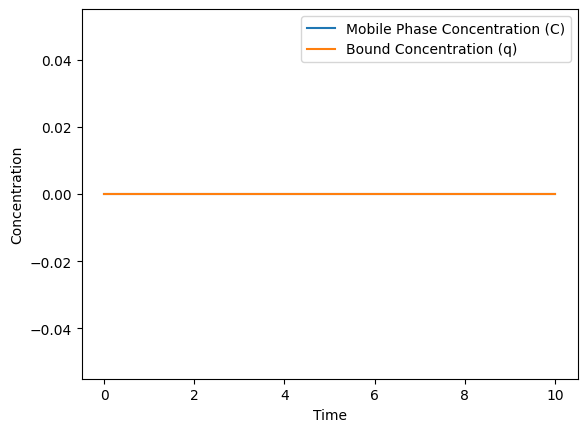

In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
k_on = 1.0    # Binding rate constant
k_off = 0.1   # Desorption rate constant
q_max = 1.0   # Maximum binding capacity

def model(y, t, C_in):
    C, q = y  # C is the concentration in the mobile phase, q is the bound concentration
    dCdt = -k_on * C * (q_max - q) + k_off * q
    dqdt = k_on * C * (q_max - q) - k_off * q
    return [dCdt, dqdt]

# Initial conditions: no initial binding
y0 = [0.0, 0.0]

# Time points
t = np.linspace(0, 10, 100)

# Concentration input profile (step function for example)
C_in = np.ones_like(t) * 1.0

# Solve ODEs
solution = odeint(model, y0, t, args=(C_in,))
C, q = solution.T

# Plot results
plt.plot(t, C, label='Mobile Phase Concentration (C)')
plt.plot(t, q, label='Bound Concentration (q)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()
